In [1]:
import sys

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge



import os
import numpy as np

In [2]:
import feature_engineering
import helper_functions
import problem
import datetime

In [3]:
%config InlineBackend.figure_format = 'retina'

In [4]:
np.random.seed(42)

In [5]:
iteration_number = datetime.datetime.now().strftime("%Y%m%d%H%M")

In [6]:
# Define the path and filename for saving tuning results
results_path = f"./model_iterations/iteration_{iteration_number}"

# Ensure the results_path exists
if not os.path.exists(results_path):
    os.makedirs(results_path)

# Load Data

In [7]:
X_train, y_train = problem.get_train_data("..")
X_test, y_test = problem.get_test_data("..")

In [8]:
# Path to results 
path_tuning = "tuning_results"

# Initalizing the Pipe

In [9]:
# Feature categories
date_features = ["hour_cos", "hour_sin", "weekday_cos", "weekday_sin", 
             "day_cos", "day_sin", "week_cos", "week_sin", "month_cos", "month_sin"]

numeric_features = ['temp', 'humidity', 'precip', 'cloudcover']
# Removed: 'velib_mean', 'velib_std', 'velib_min', 'velib_25%', 'latitude', 'longitude', 'windspeed' 

categorical_features = ["counter_name", "site_name"]
# Removed:  "year"

binary_features = ["precipprob", "in_Lockdown", "is_Bank_Holiday", 
                   "if_School_Holiday", "is_workday"]
# Removed:  "is_Rush_Hour"

# Function to transform and add additional features
feature_transformer = FunctionTransformer(feature_engineering._additional_features)

# Preprocessing pipeline
data_preprocessor = ColumnTransformer([
    ("numeric_scaler", StandardScaler(), numeric_features),
    ("categorical_onehot", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ("binary_passthrough", "passthrough", binary_features),
    ("date_onehot", "passthrough", date_features)
])

# Model Evaluation

## LightGBM

In [10]:
light_gbm_params = pd.read_csv(os.path.join(path_tuning, 'tuning_LightGBM/202311271915_results.csv'))

In [11]:
light_gbm_max_params = light_gbm_params.loc[light_gbm_params['mean_test_score'] == light_gbm_params['mean_test_score'].max()]


In [12]:
print(f"Mean Train set, RMSE = {light_gbm_max_params['mean_train_score'].values[0]:.2f}")
print(f"Mean Test  set, RMSE = {light_gbm_max_params['mean_test_score'].values[0]:.2f}")

Mean Train set, RMSE = -0.39
Mean Test  set, RMSE = -0.71


In [13]:
# Define hyperparameters for tuning
model = LGBMRegressor(
        n_estimators=light_gbm_max_params['param_lgbmregressor__n_estimators'].values[0],
        learning_rate=light_gbm_max_params['param_lgbmregressor__learning_rate'].values[0],
        num_leaves=light_gbm_max_params['param_lgbmregressor__num_leaves'].values[0],
        min_child_samples=light_gbm_max_params['param_lgbmregressor__min_child_samples'].values[0],
        subsample=light_gbm_max_params['param_lgbmregressor__subsample'].values[0],
        subsample_freq=light_gbm_max_params['param_lgbmregressor__subsample_freq'].values[0],
        colsample_bytree=light_gbm_max_params['param_lgbmregressor__colsample_bytree'].values[0]
)


In [19]:
reg_pipe = make_pipeline(feature_transformer, data_preprocessor, model)

reg_pipe.fit(X_train, y_train)

y_train_prediction = reg_pipe.predict(X_train)
y_test_prediction = reg_pipe.predict(X_test)

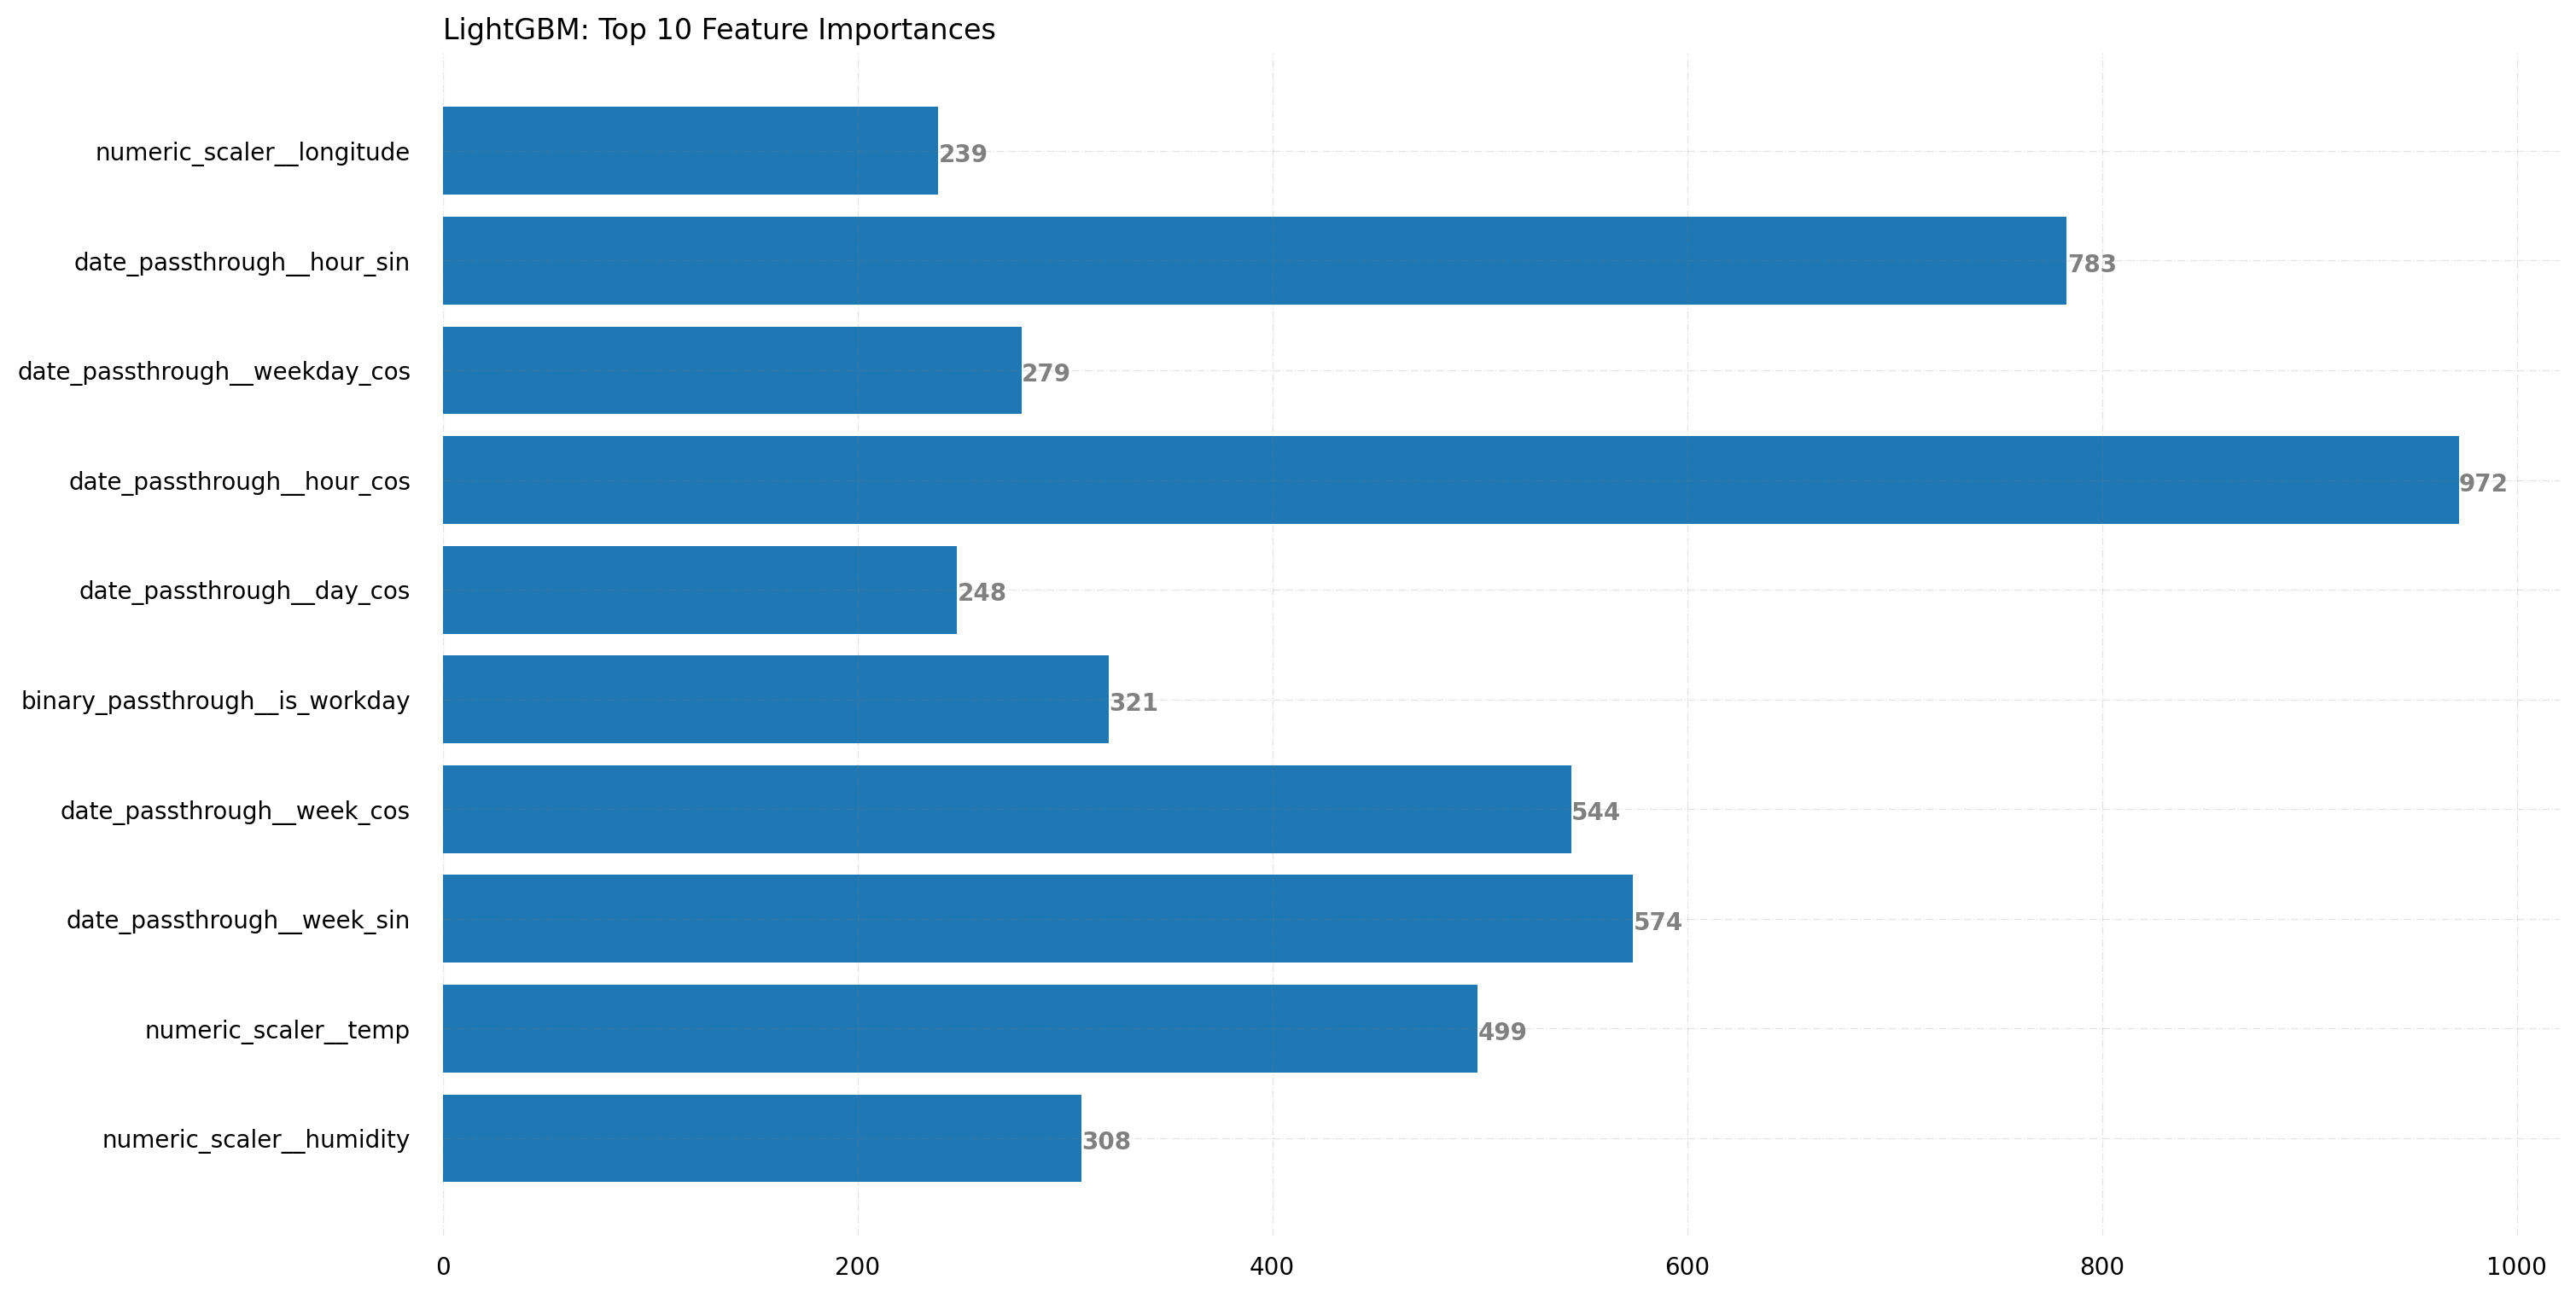

In [17]:
ind = np.argpartition(model.feature_importances_, -10)[-10:]

features = data_preprocessor.get_feature_names_out()[ind]
importance = model.feature_importances_[ind]

helper_functions.feature_importance(features, importance, 'LightGBM', results_path)

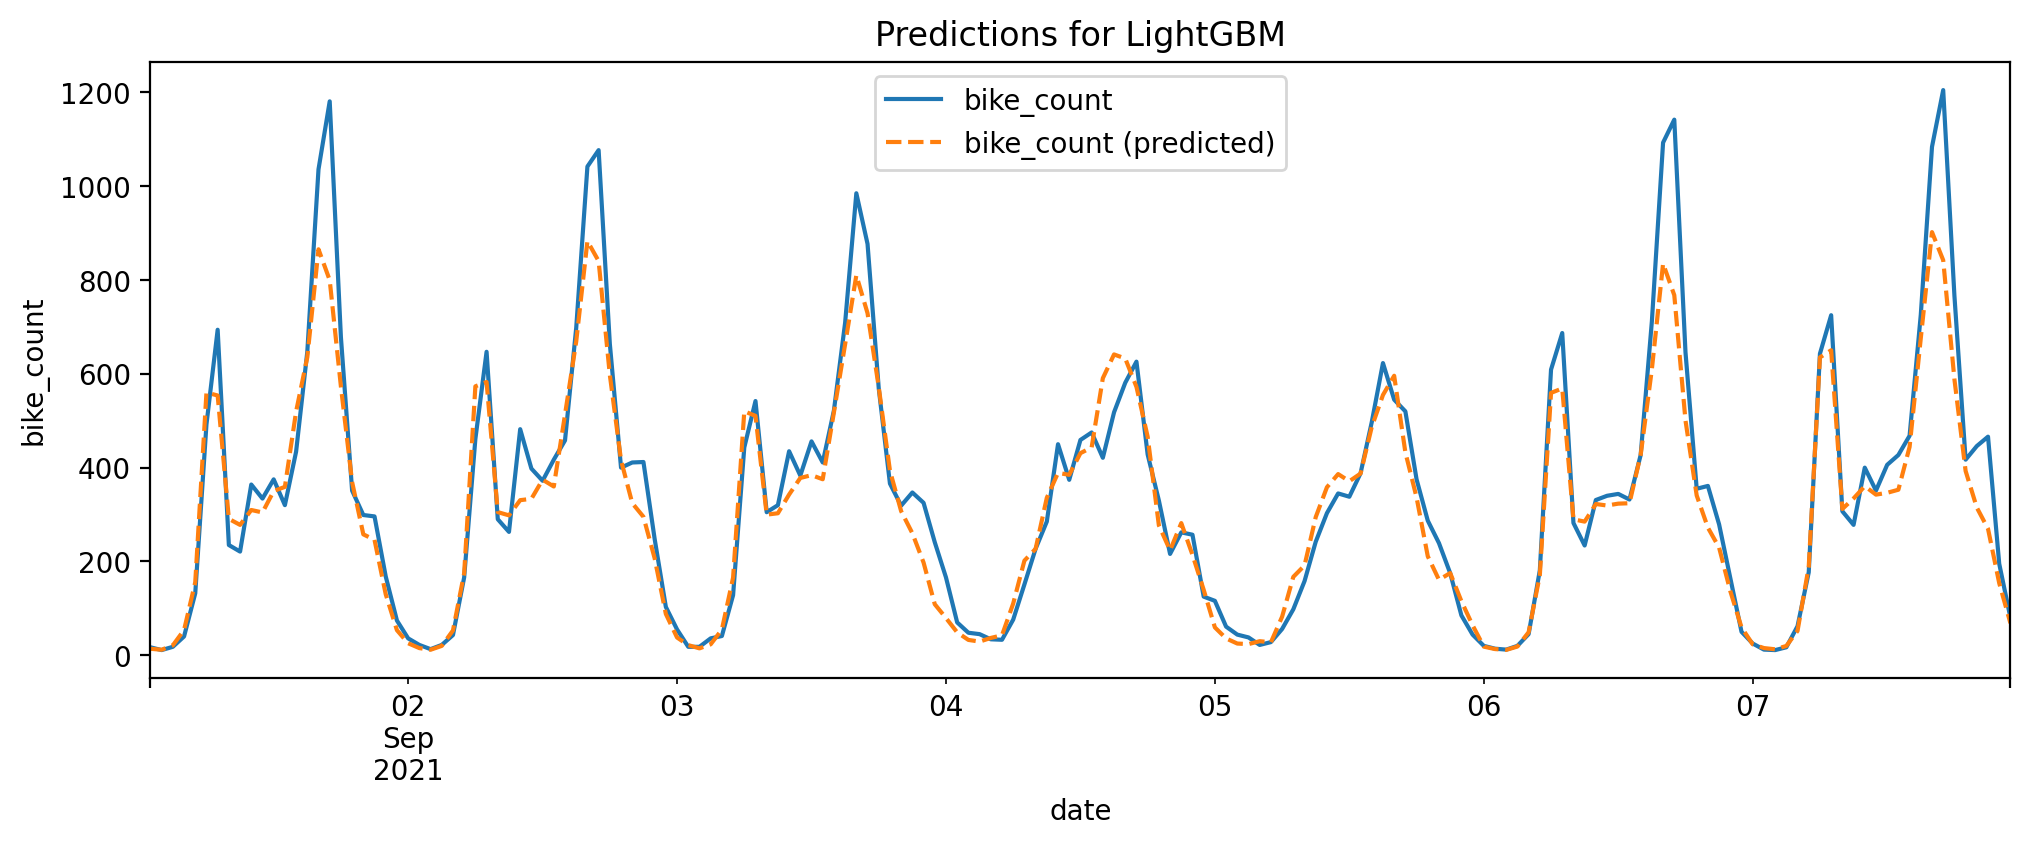

In [20]:
helper_functions.sample_week_plot(X_test, y_test_prediction, y_test, 'LightGBM', results_path)

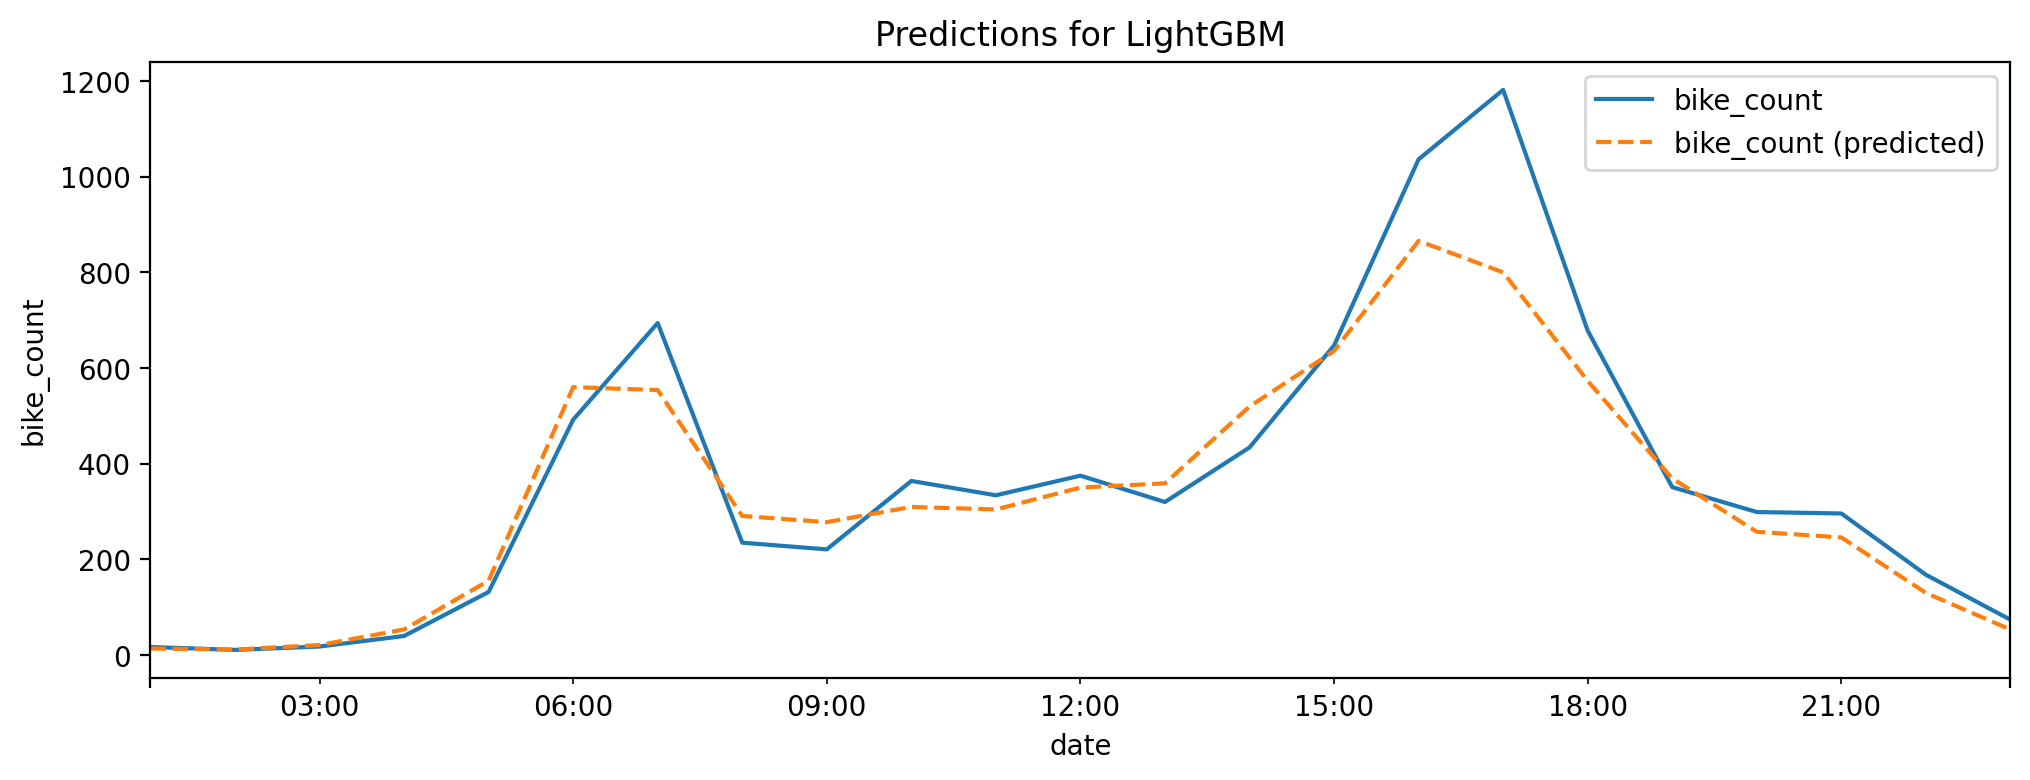

In [21]:
helper_functions.sample_day_plot(X_test, y_test_prediction, y_test, 'LightGBM', results_path)

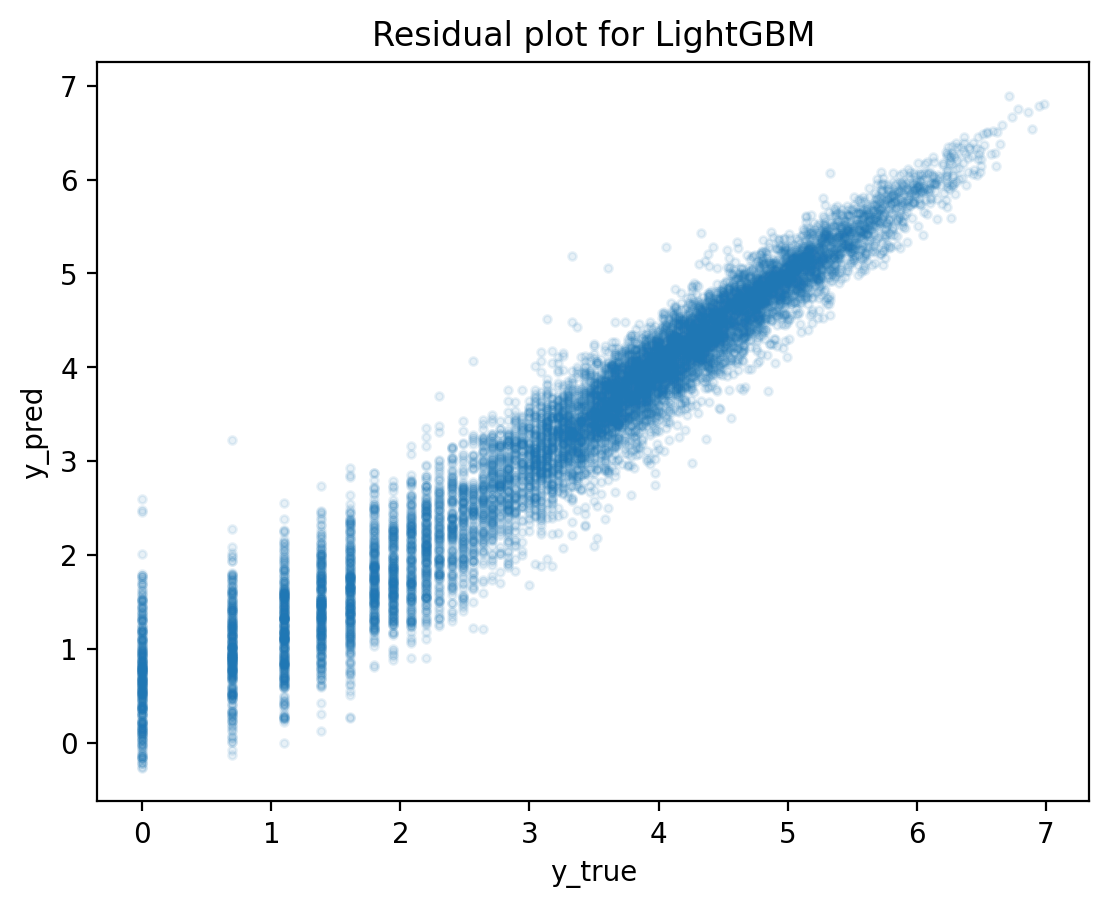

In [22]:
helper_functions.residual_plot(y_test_prediction, y_test, 'LightGBM', results_path)

# XGBoost

In [23]:
xgb_params = pd.read_csv(os.path.join(path_tuning, 'tuning_XGB/202311271920_results.csv'))

In [24]:
xgb_max_params = xgb_params.loc[xgb_params['mean_test_score'] == xgb_params['mean_test_score'].max()]


In [25]:
print(f"Mean Train set, RMSE = {xgb_max_params['mean_train_score'].values[0]:.2f}")
print(f"Mean Test  set, RMSE = {xgb_max_params['mean_test_score'].values[0]:.2f}")

Mean Train set, RMSE = -0.57
Mean Test  set, RMSE = -0.79


In [26]:
# Define hyperparameters for tuning
model = XGBRegressor(
        n_estimators=xgb_max_params['param_xgbregressor__n_estimators'].values[0],
        learning_rate=xgb_max_params['param_xgbregressor__learning_rate'].values[0],
        colsample_bytree=xgb_max_params['param_xgbregressor__colsample_bytree'].values[0],
        colsample_bylevel=xgb_max_params['param_xgbregressor__colsample_bylevel'].values[0],
        colsample_bynode=xgb_max_params['param_xgbregressor__colsample_bynode'].values[0],
        max_depth=xgb_max_params['param_xgbregressor__max_depth'].values[0],
        subsample=xgb_max_params['param_xgbregressor__subsample'].values[0]
)

In [27]:
reg_pipe = make_pipeline(feature_transformer, data_preprocessor, model)
reg_pipe.fit(X_train, y_train)

y_train_prediction = reg_pipe.predict(X_train)
y_test_prediction = reg_pipe.predict(X_test)

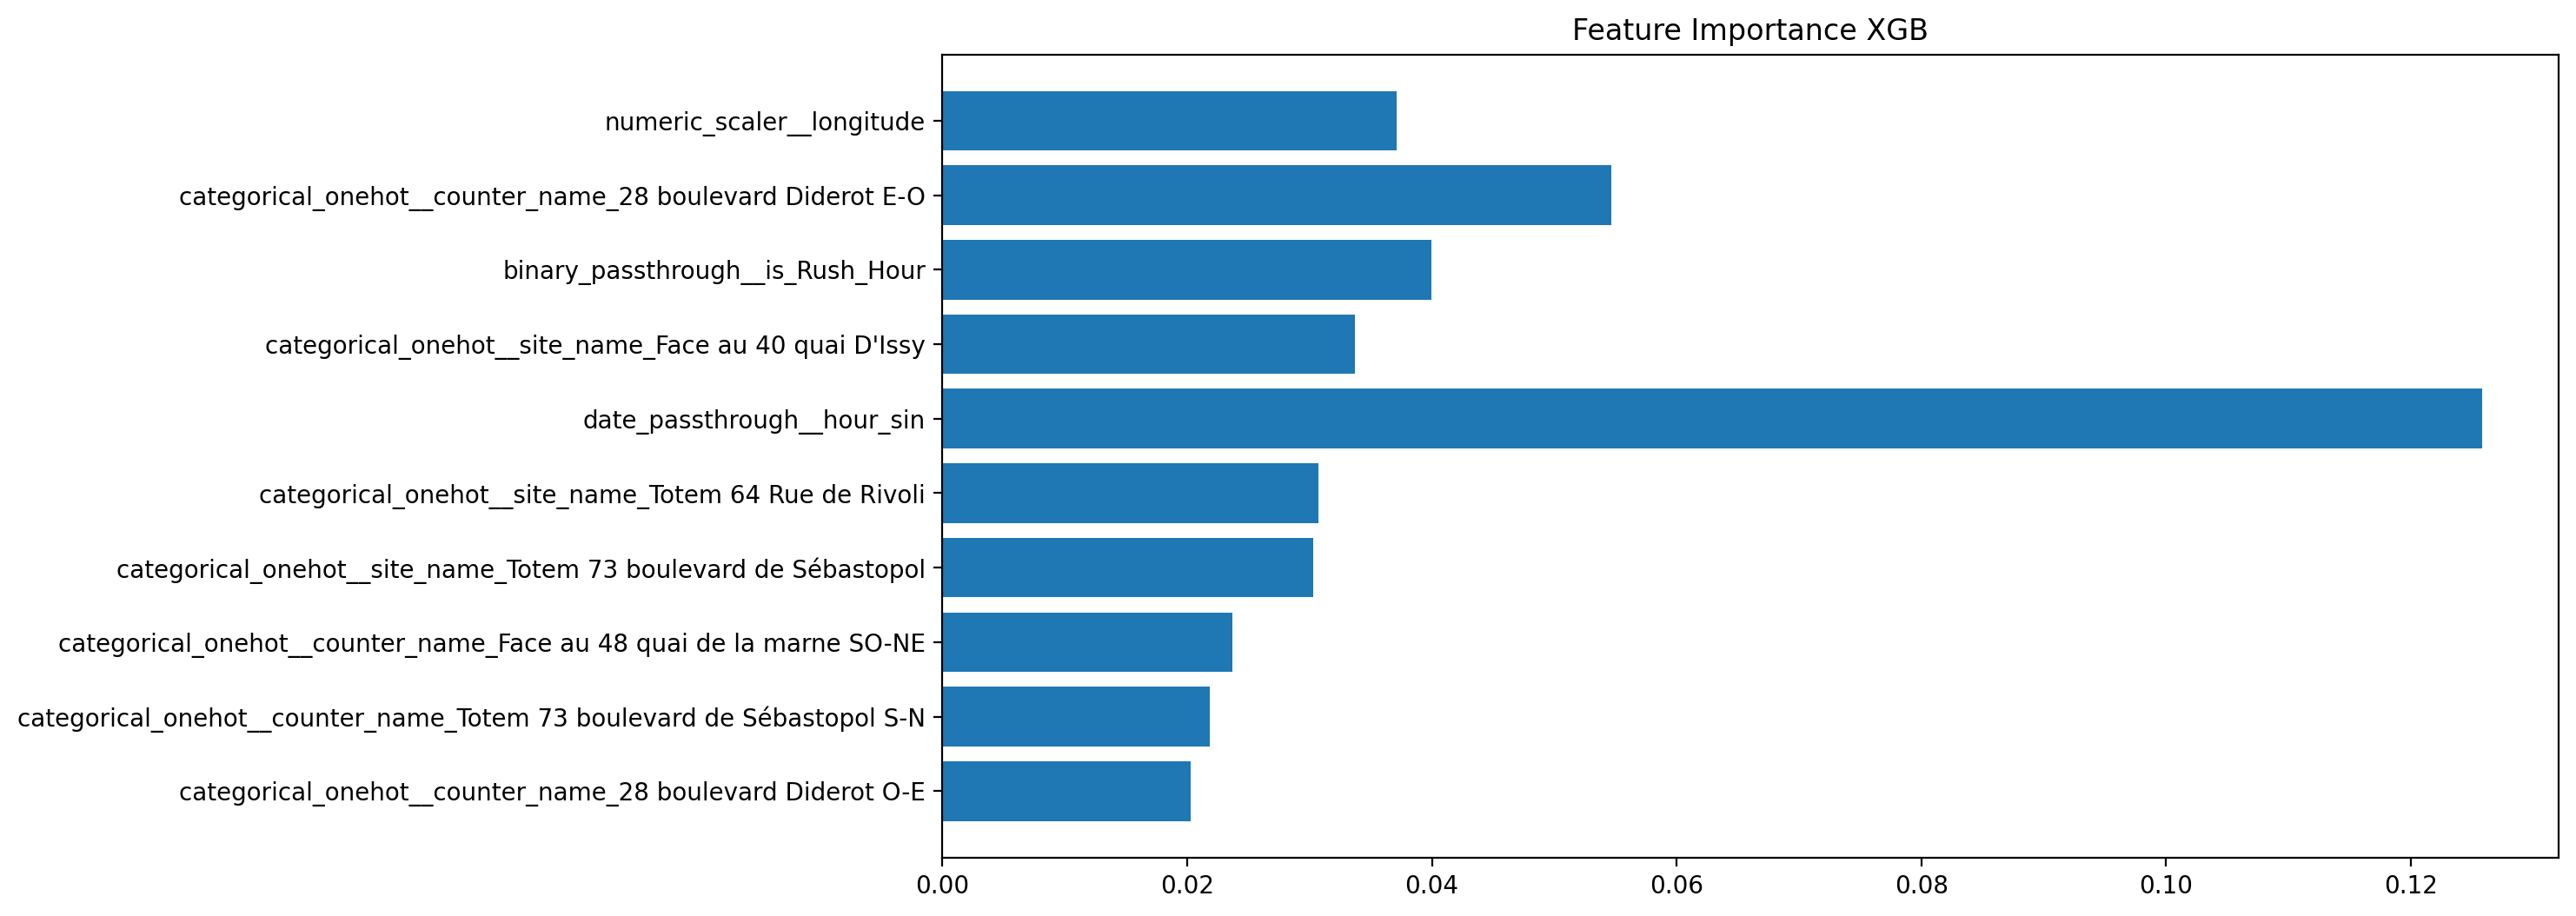

In [28]:
ind = np.argpartition(model.feature_importances_, -10)[-10:]

features = data_preprocessor.get_feature_names_out()[ind]
importance = model.feature_importances_[ind]

fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(ind)), importance, align='center')
plt.yticks(range(len(ind)), features)
plt.title('Feature Importance XGB')
plt.savefig(f'{results_path}/feature_importance_XGB.png')
plt.show()

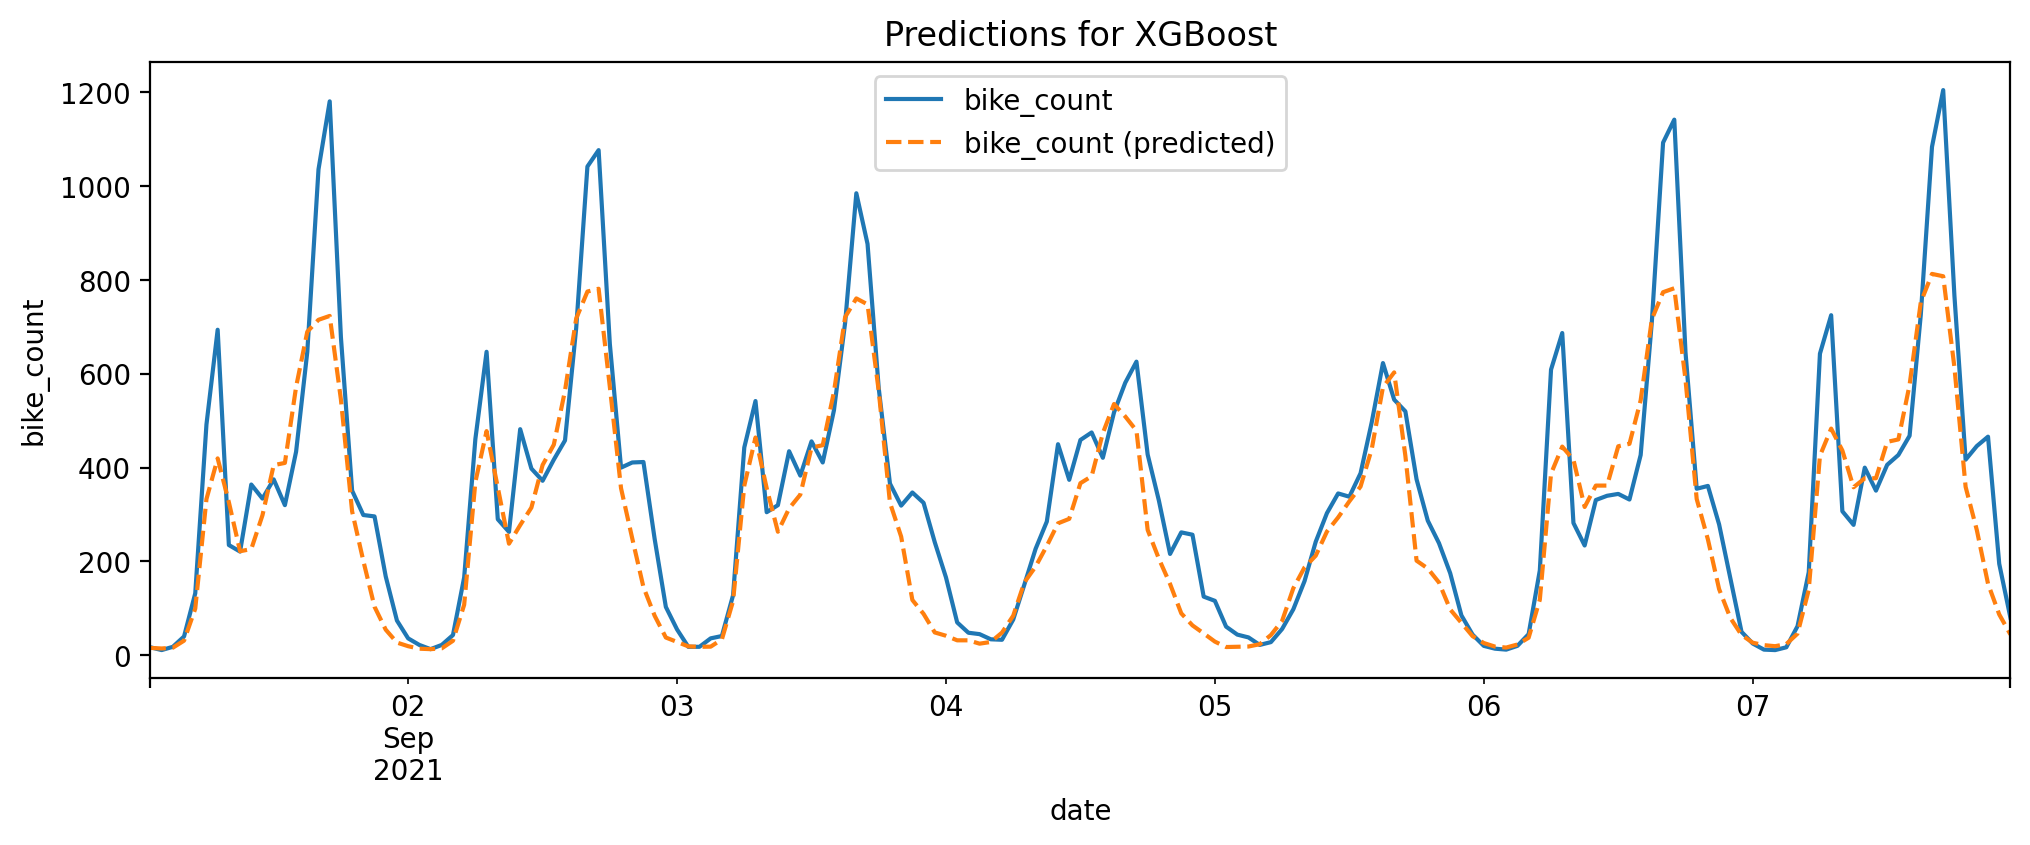

In [29]:
helper_functions.sample_week_plot(X_test, y_test_prediction, y_test, 'XGBoost', results_path)


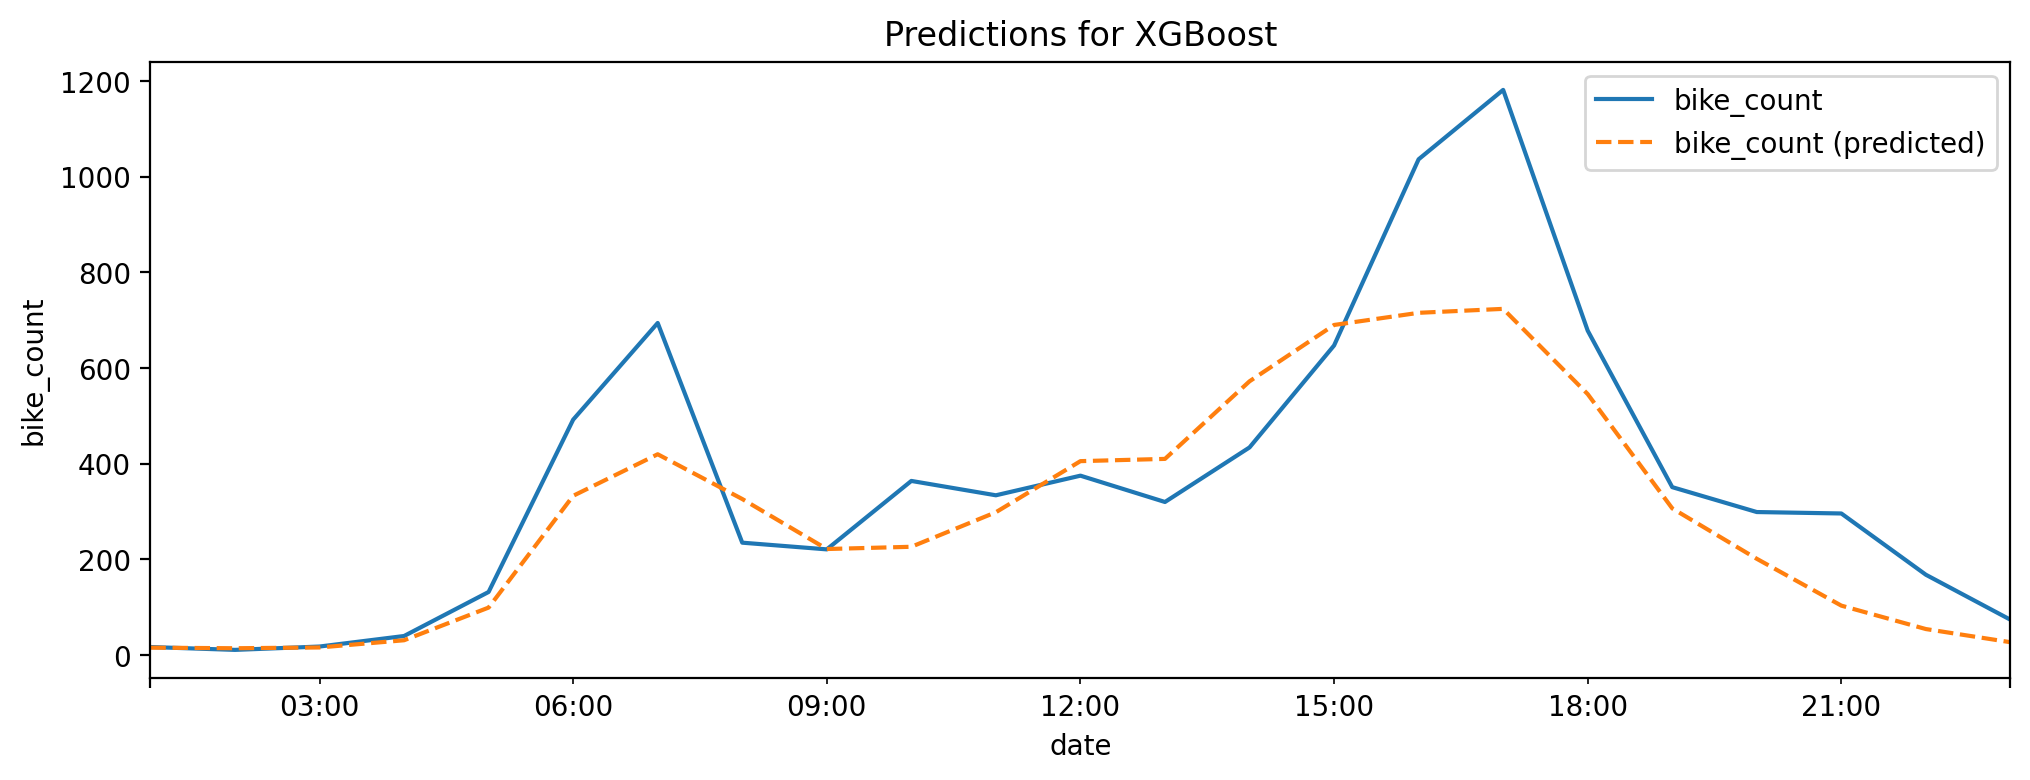

In [30]:
helper_functions.sample_day_plot(X_test, y_test_prediction, y_test, 'XGBoost', results_path)


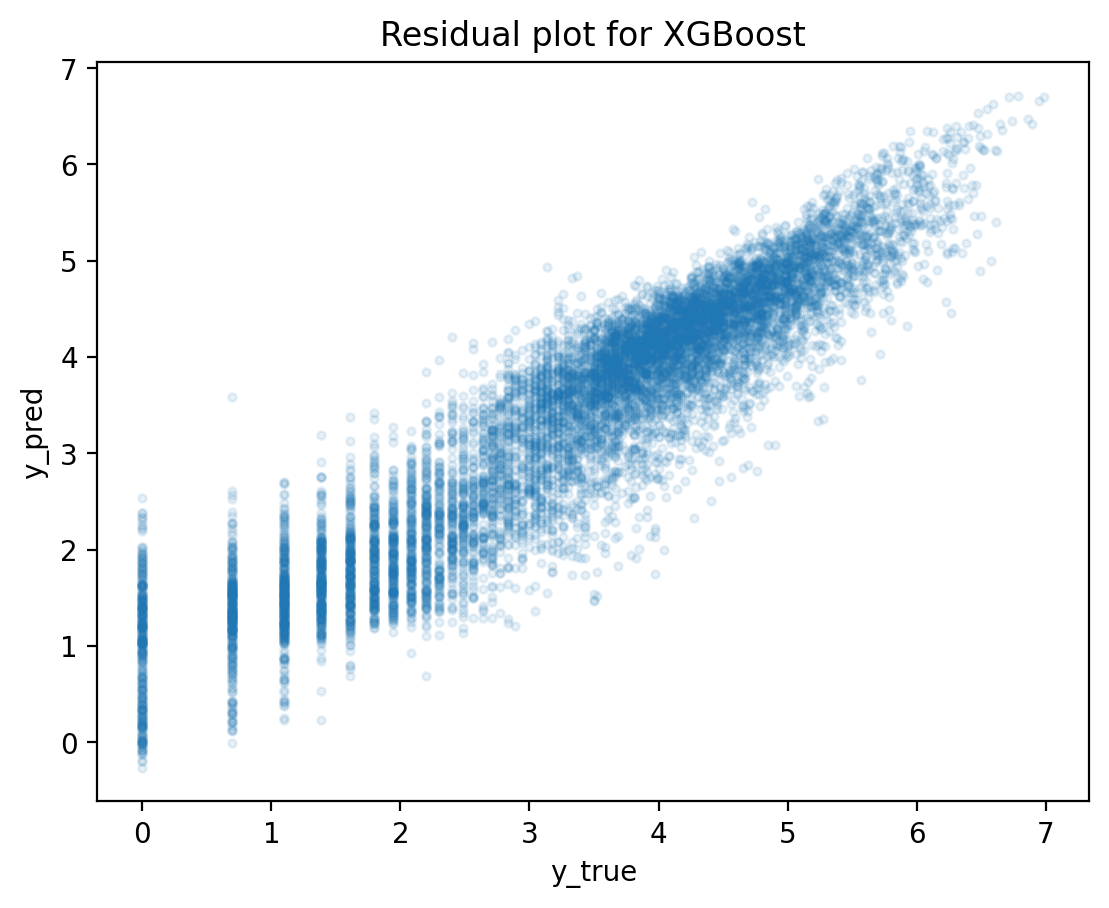

In [31]:
helper_functions.residual_plot(y_test_prediction, y_test, 'XGBoost', results_path)


## MLP Network

In [32]:
mlp_params = pd.read_csv(os.path.join(path_tuning, 'tuning_mlp/202311272002_results.csv'))

In [33]:
mlp_max_params = mlp_params.loc[mlp_params['mean_test_score'] == mlp_params['mean_test_score'].max()]

In [34]:
print(f"Mean Train set, RMSE = {mlp_max_params['mean_train_score'].values[0]:.2f}")
print(f"Mean Test  set, RMSE = {mlp_max_params['mean_test_score'].values[0]:.2f}")

Mean Train set, RMSE = -0.39
Mean Test  set, RMSE = -0.94


In [53]:
# Define hyperparameters for tuning
model = MLPRegressor(
        hidden_layer_sizes=[eval(i) for i in mlp_max_params['param_mlpregressor__hidden_layer_sizes'].values[0].strip('()').split(', ')],
        activation=mlp_max_params['param_mlpregressor__activation'].values[0],
        solver=mlp_max_params['param_mlpregressor__solver'].values[0],
        alpha=mlp_max_params['param_mlpregressor__alpha'].values[0],
        learning_rate=mlp_max_params['param_mlpregressor__learning_rate'].values[0],
        learning_rate_init=mlp_max_params['param_mlpregressor__learning_rate_init'].values[0],
        max_iter=mlp_max_params['param_mlpregressor__max_iter'].values[0]
)

In [54]:
reg_pipe = make_pipeline(feature_transformer, data_preprocessor, model)

reg_pipe.fit(X_train, y_train)

y_train_prediction = reg_pipe.predict(X_train)
y_test_prediction = reg_pipe.predict(X_test)

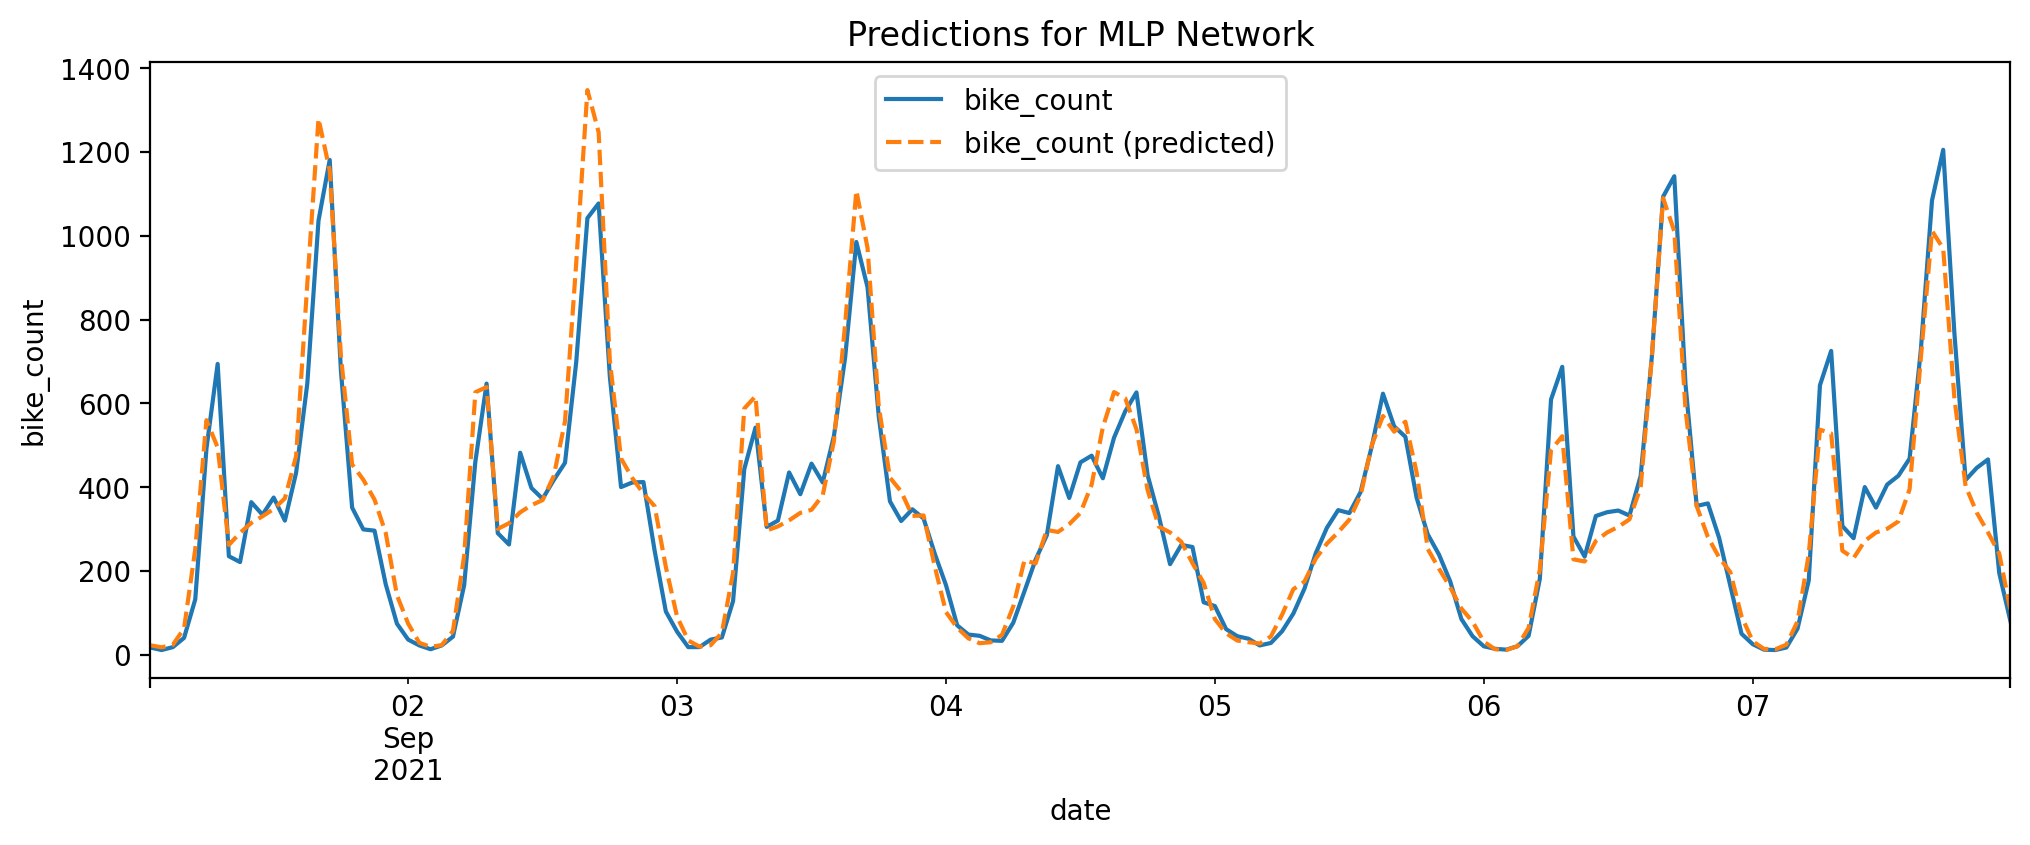

In [55]:
helper_functions.sample_week_plot(X_test, y_test_prediction, y_test, 'MLP Network', results_path)

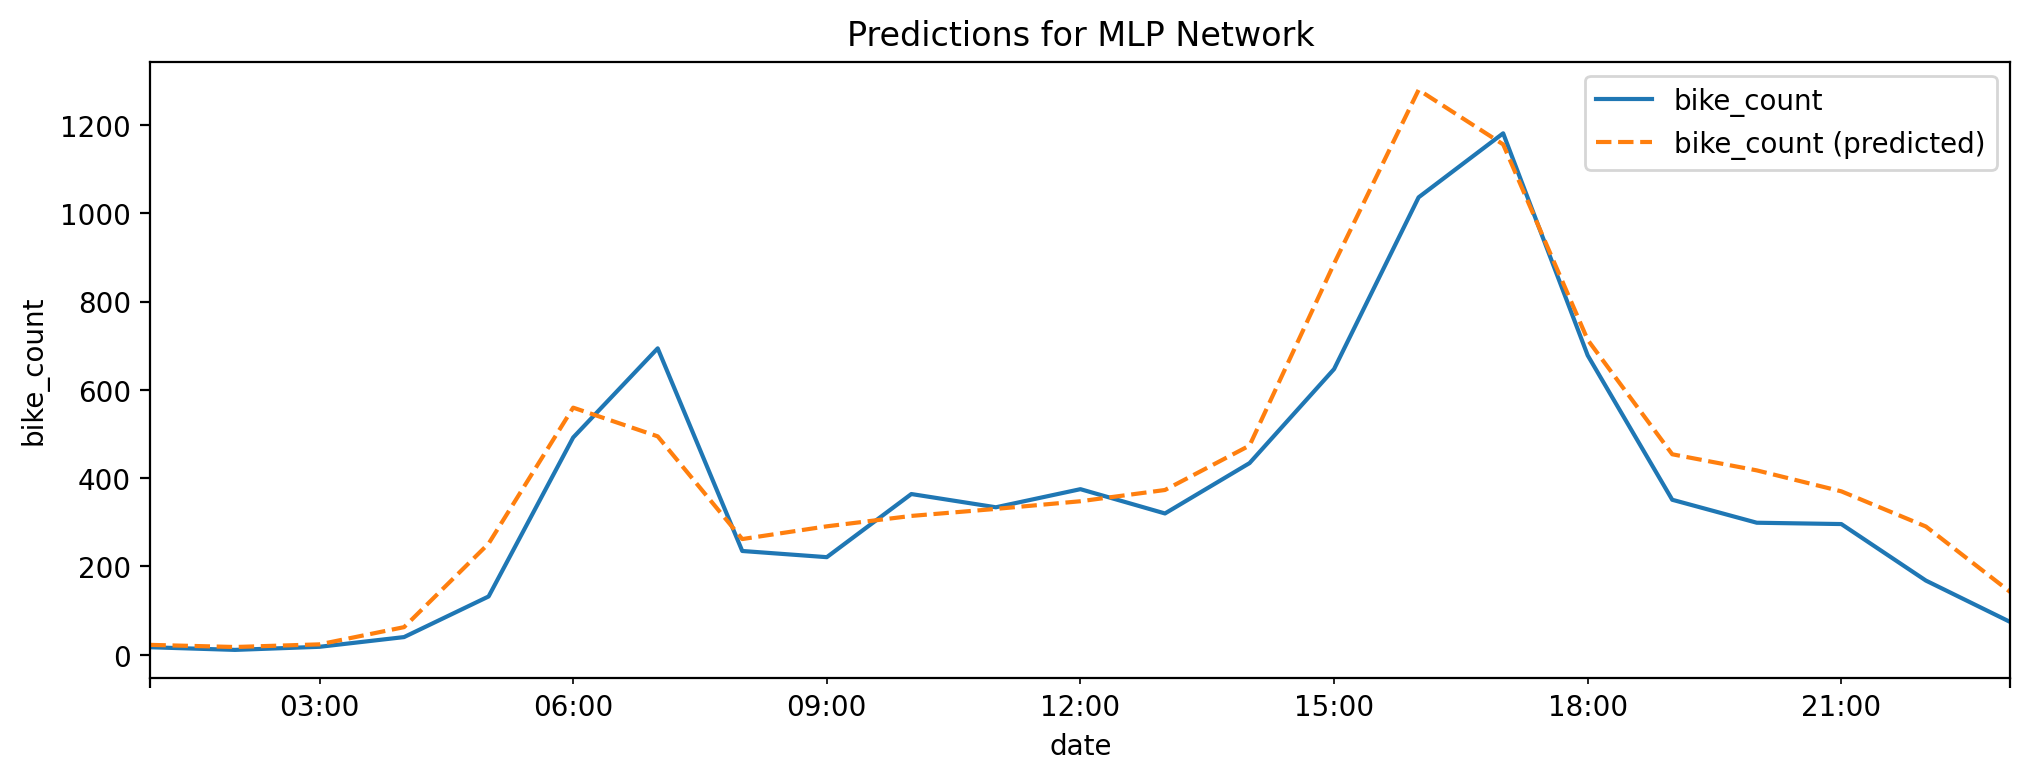

In [56]:
helper_functions.sample_day_plot(X_test, y_test_prediction, y_test, 'MLP Network', results_path)

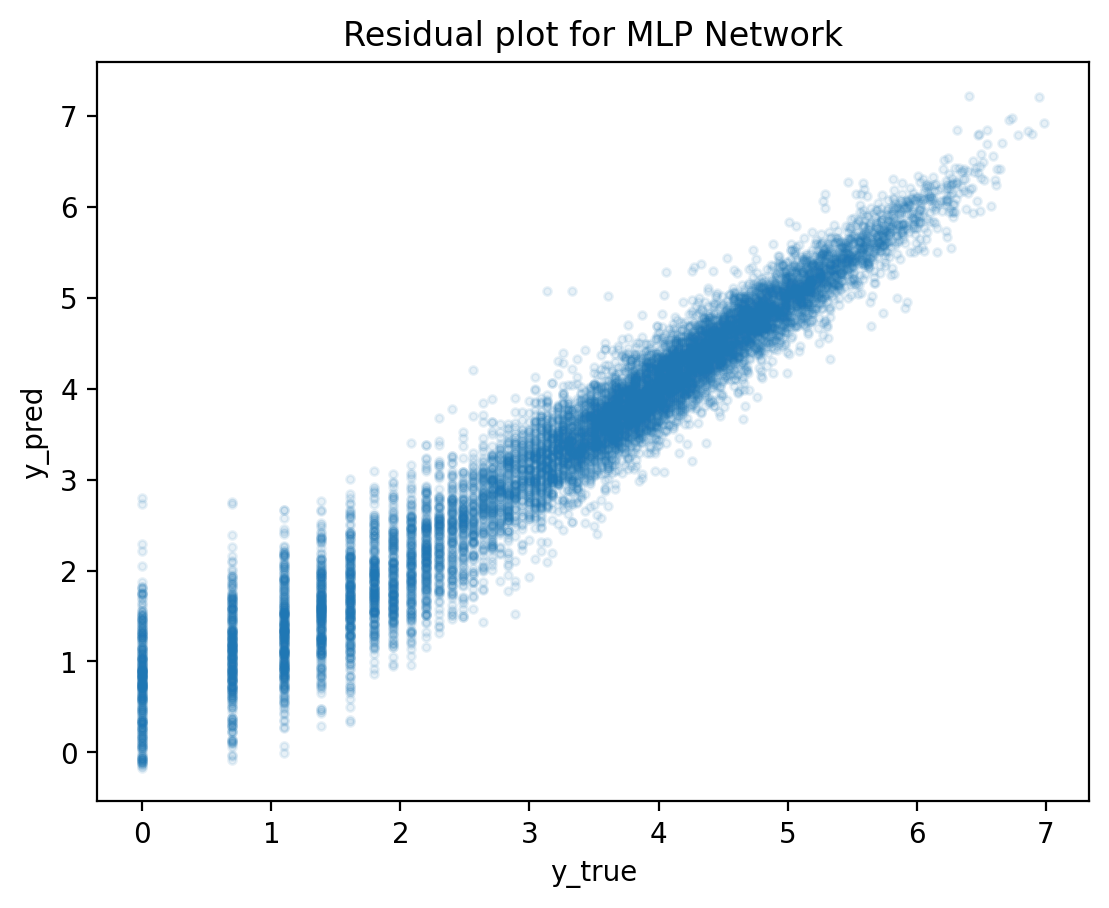

In [57]:
helper_functions.residual_plot(y_test_prediction, y_test, 'MLP Network', results_path)

## ElasticNet

In [58]:
elasticnet_params = pd.read_csv(os.path.join(path_tuning, 'tuning_ElasticNet/202311271926_results.csv'))

In [59]:
elasticnet_max_params = elasticnet_params.loc[elasticnet_params['mean_test_score'] == elasticnet_params['mean_test_score'].max()]

In [60]:
print(f"Mean Train set, RMSE = {elasticnet_params['mean_train_score'].values[0]:.2f}")
print(f"Mean Test  set, RMSE = {elasticnet_params['mean_test_score'].values[0]:.2f}")

Mean Train set, RMSE = -1.07
Mean Test  set, RMSE = -1.11


In [61]:
# Define hyperparameters for tuning
model = ElasticNet(
        l1_ratio=elasticnet_max_params['param_elasticnet__l1_ratio'].values[0],
        alpha=elasticnet_max_params['param_elasticnet__alpha'].values[0],
)

In [62]:
reg_pipe = make_pipeline(feature_transformer, data_preprocessor, model)
reg_pipe.fit(X_train, y_train)

y_train_prediction = reg_pipe.predict(X_train)
y_test_prediction = reg_pipe.predict(X_test)

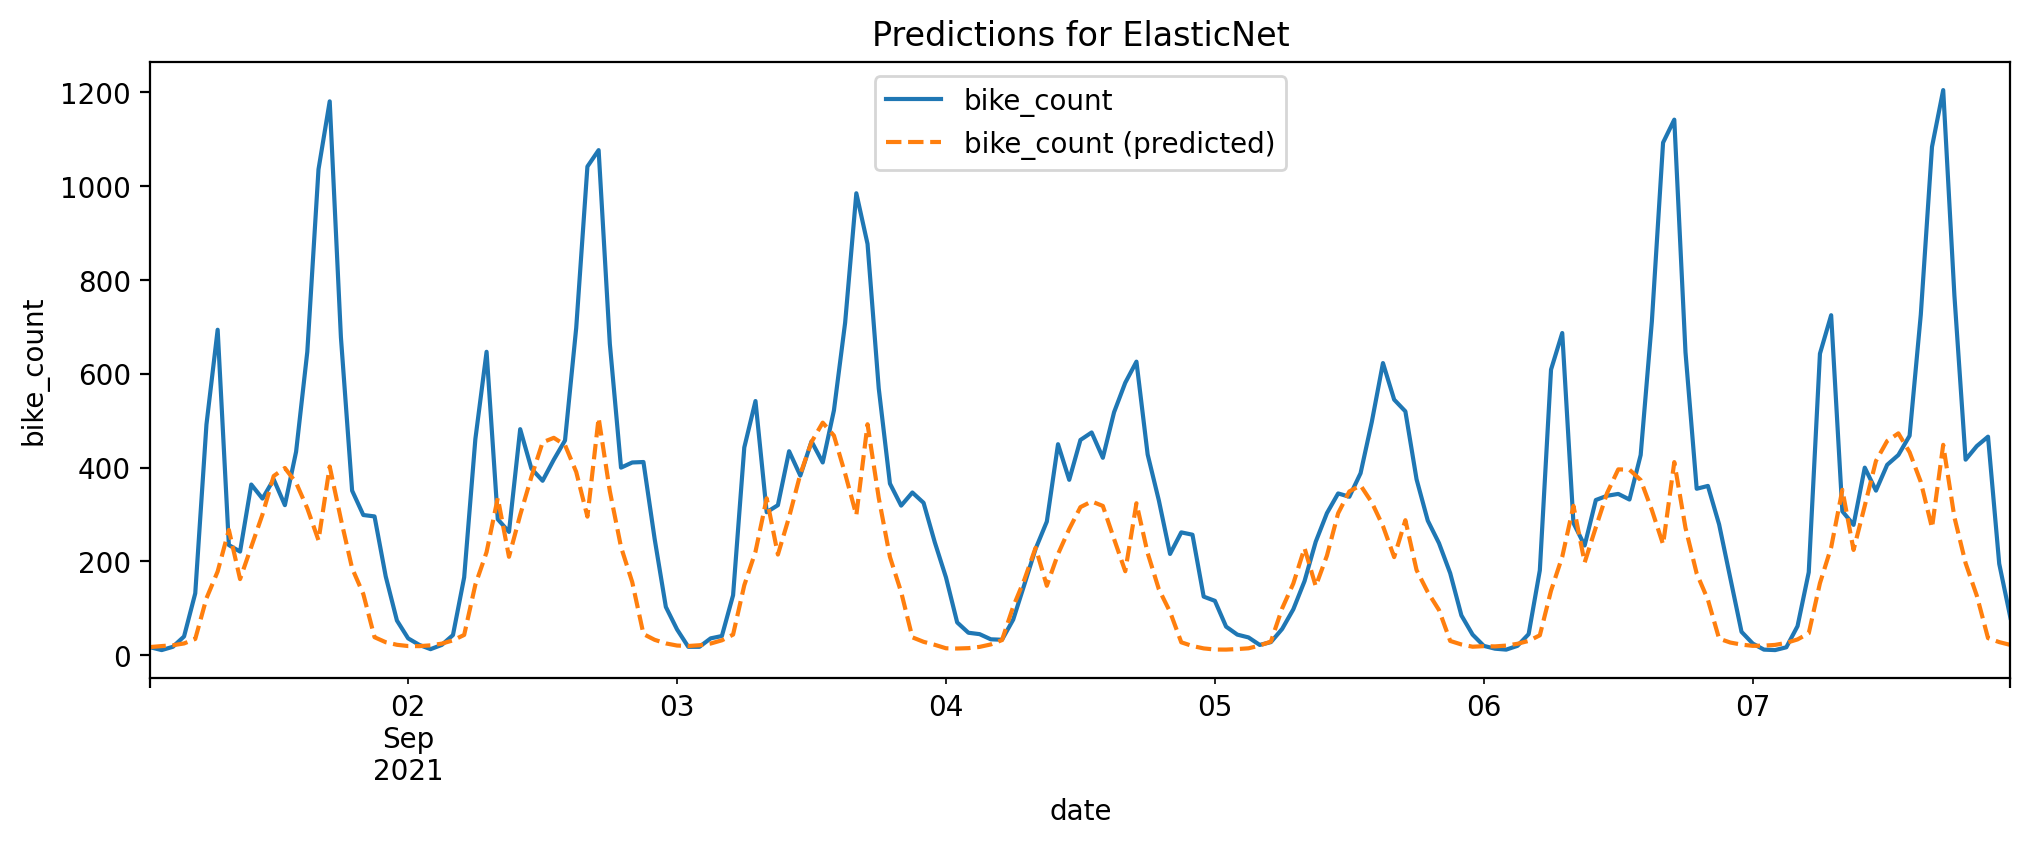

In [63]:
helper_functions.sample_week_plot(X_test, y_test_prediction, y_test, 'ElasticNet', results_path)

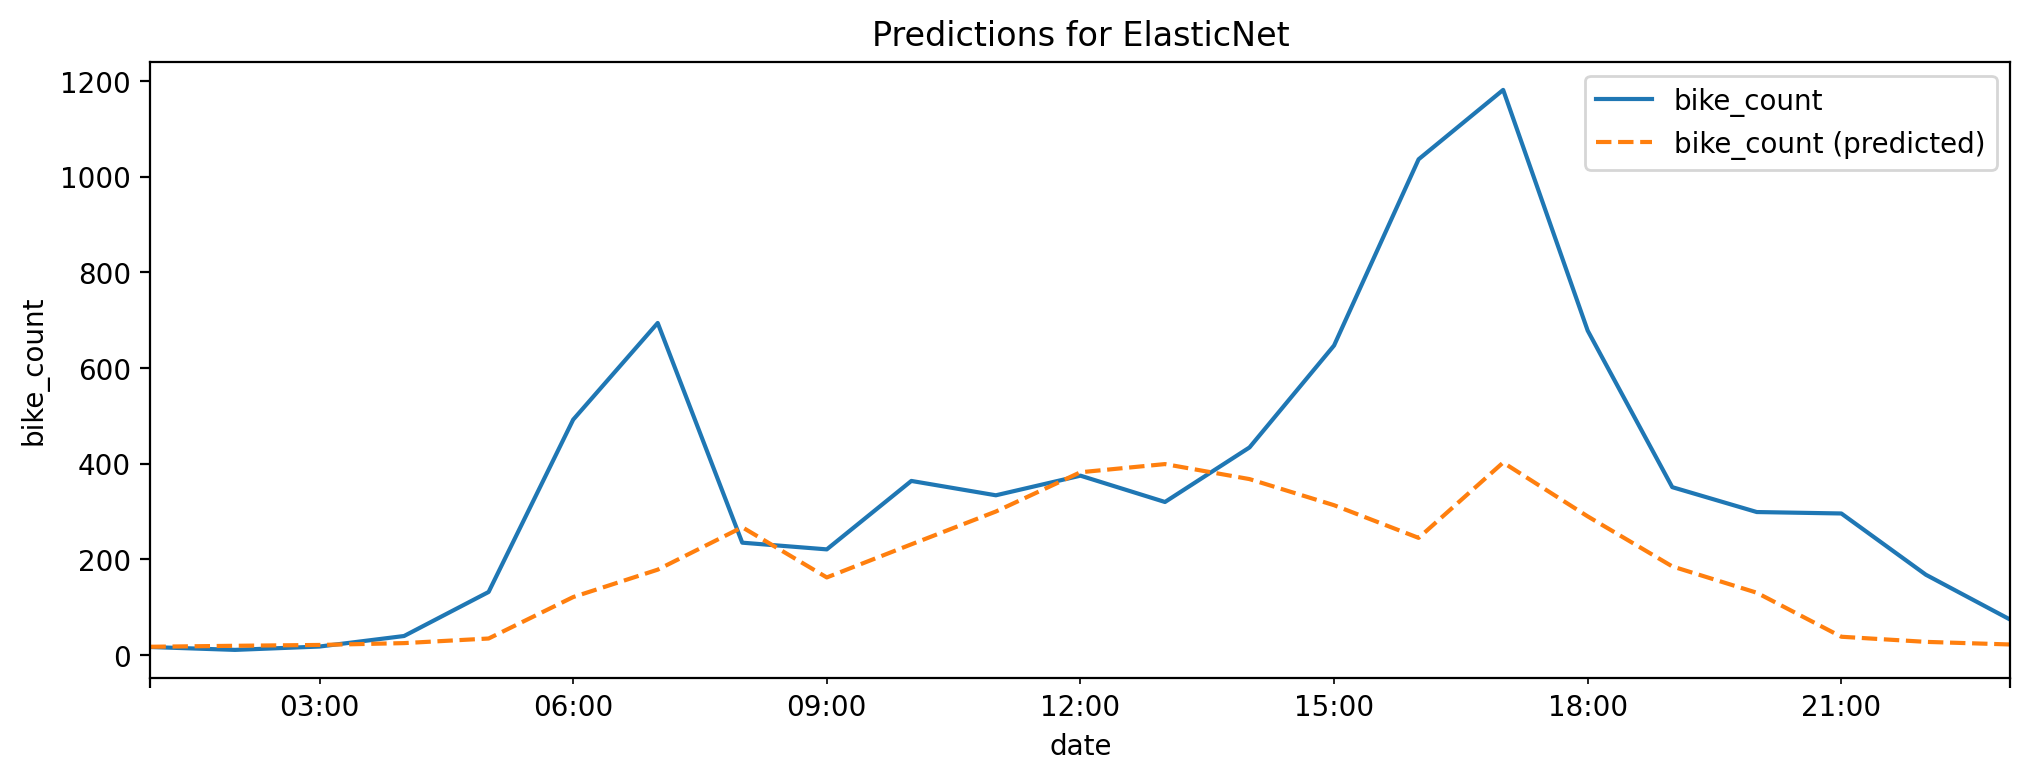

In [64]:
helper_functions.sample_day_plot(X_test, y_test_prediction, y_test, 'ElasticNet', results_path)

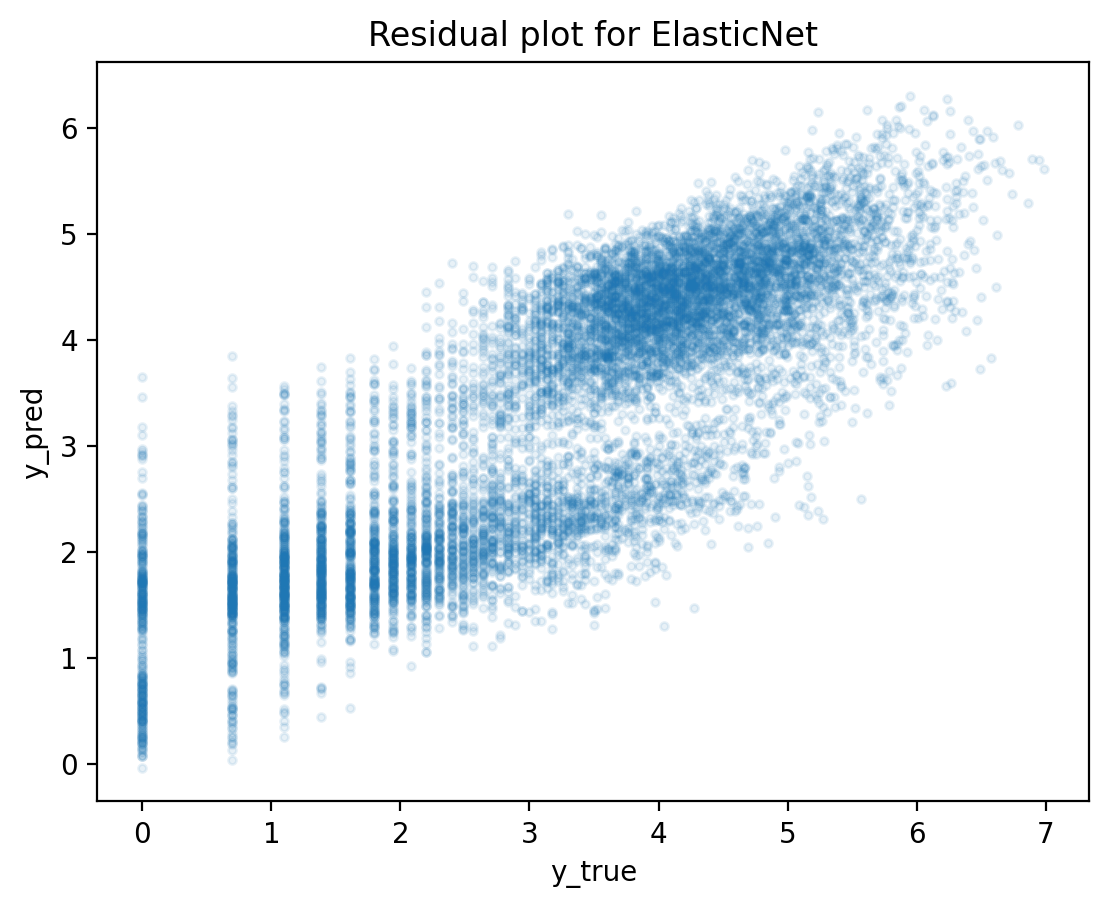

In [65]:
helper_functions.residual_plot(y_test_prediction, y_test, 'ElasticNet', results_path)

## Ridge

In [66]:
ridge_params = pd.read_csv(os.path.join(path_tuning, 'tuning_Ridge/202311271933_results.csv'))

In [67]:
ridge_max_params = ridge_params.loc[ridge_params['mean_test_score'] == ridge_params['mean_test_score'].max()]

In [68]:
print(f"Mean Train set, RMSE = {ridge_params['mean_train_score'].values[0]:.2f}")
print(f"Mean Test  set, RMSE = {ridge_params['mean_test_score'].values[0]:.2f}")

Mean Train set, RMSE = -0.80
Mean Test  set, RMSE = -0.93


In [69]:
# Define hyperparameters for tuning
model = Ridge(
        alpha=ridge_max_params['param_ridge__alpha'].values[0],
)

In [70]:
reg_pipe = make_pipeline(feature_transformer, data_preprocessor, model)
reg_pipe.fit(X_train, y_train)

y_train_prediction = reg_pipe.predict(X_train)
y_test_prediction = reg_pipe.predict(X_test)

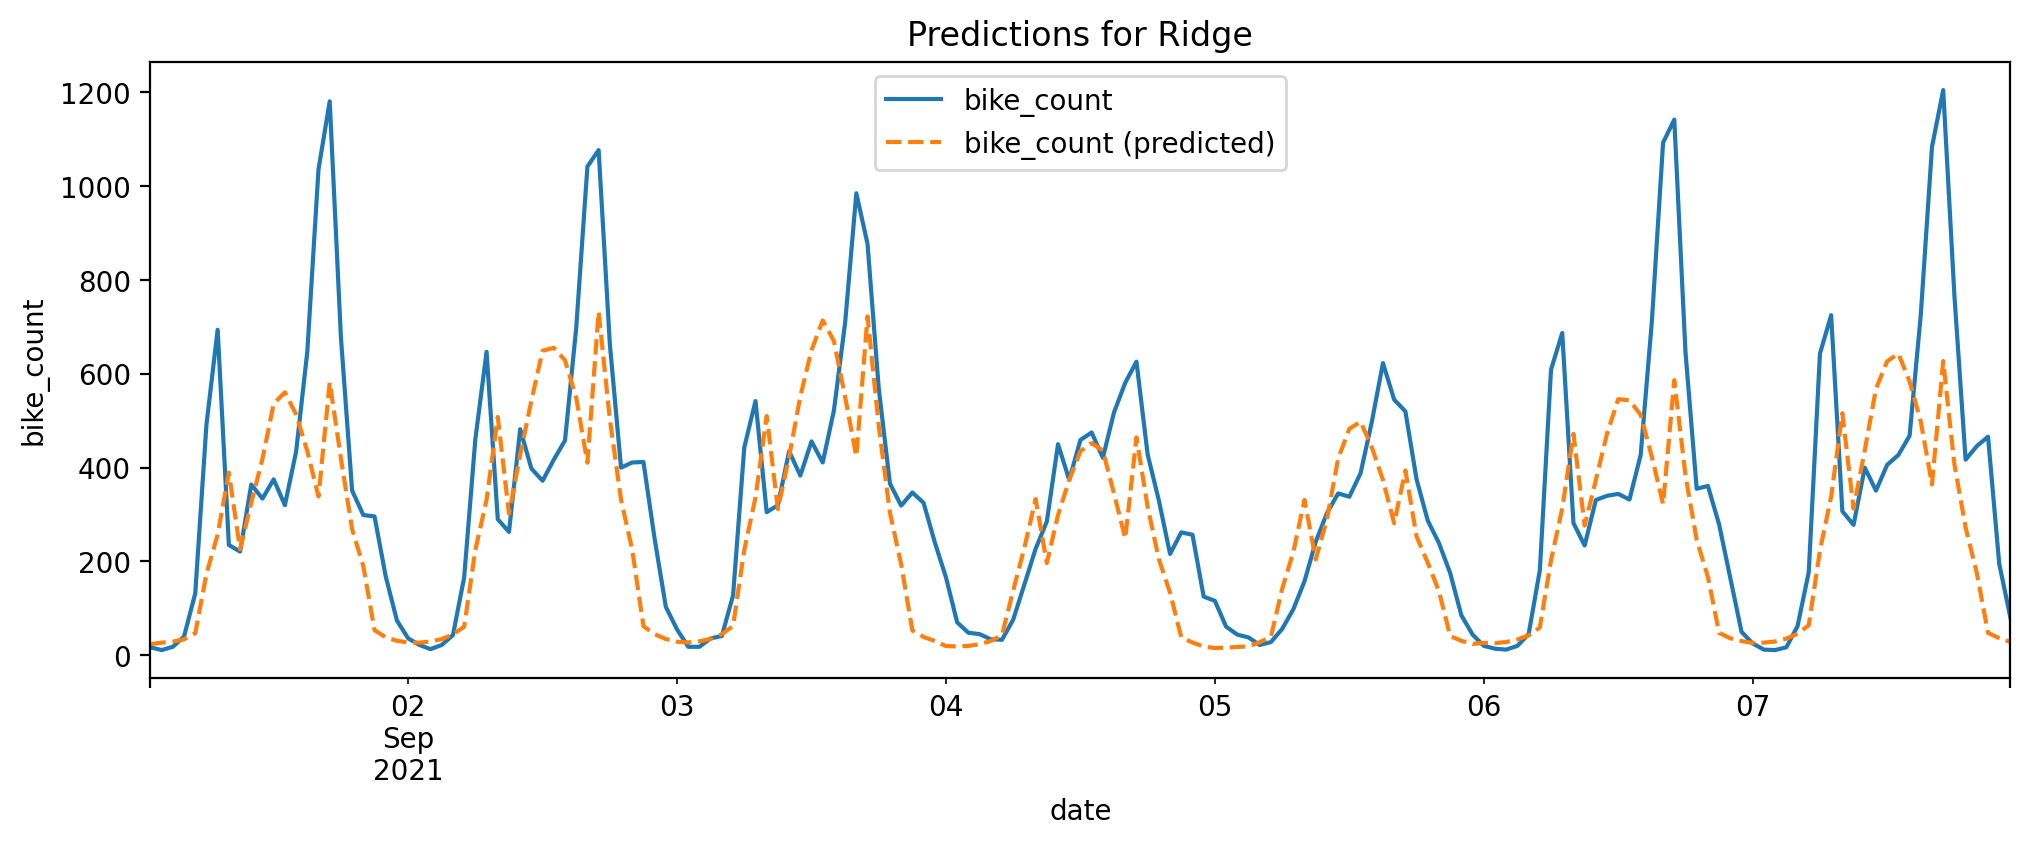

In [71]:
helper_functions.sample_week_plot(X_test, y_test_prediction, y_test, 'Ridge', results_path)

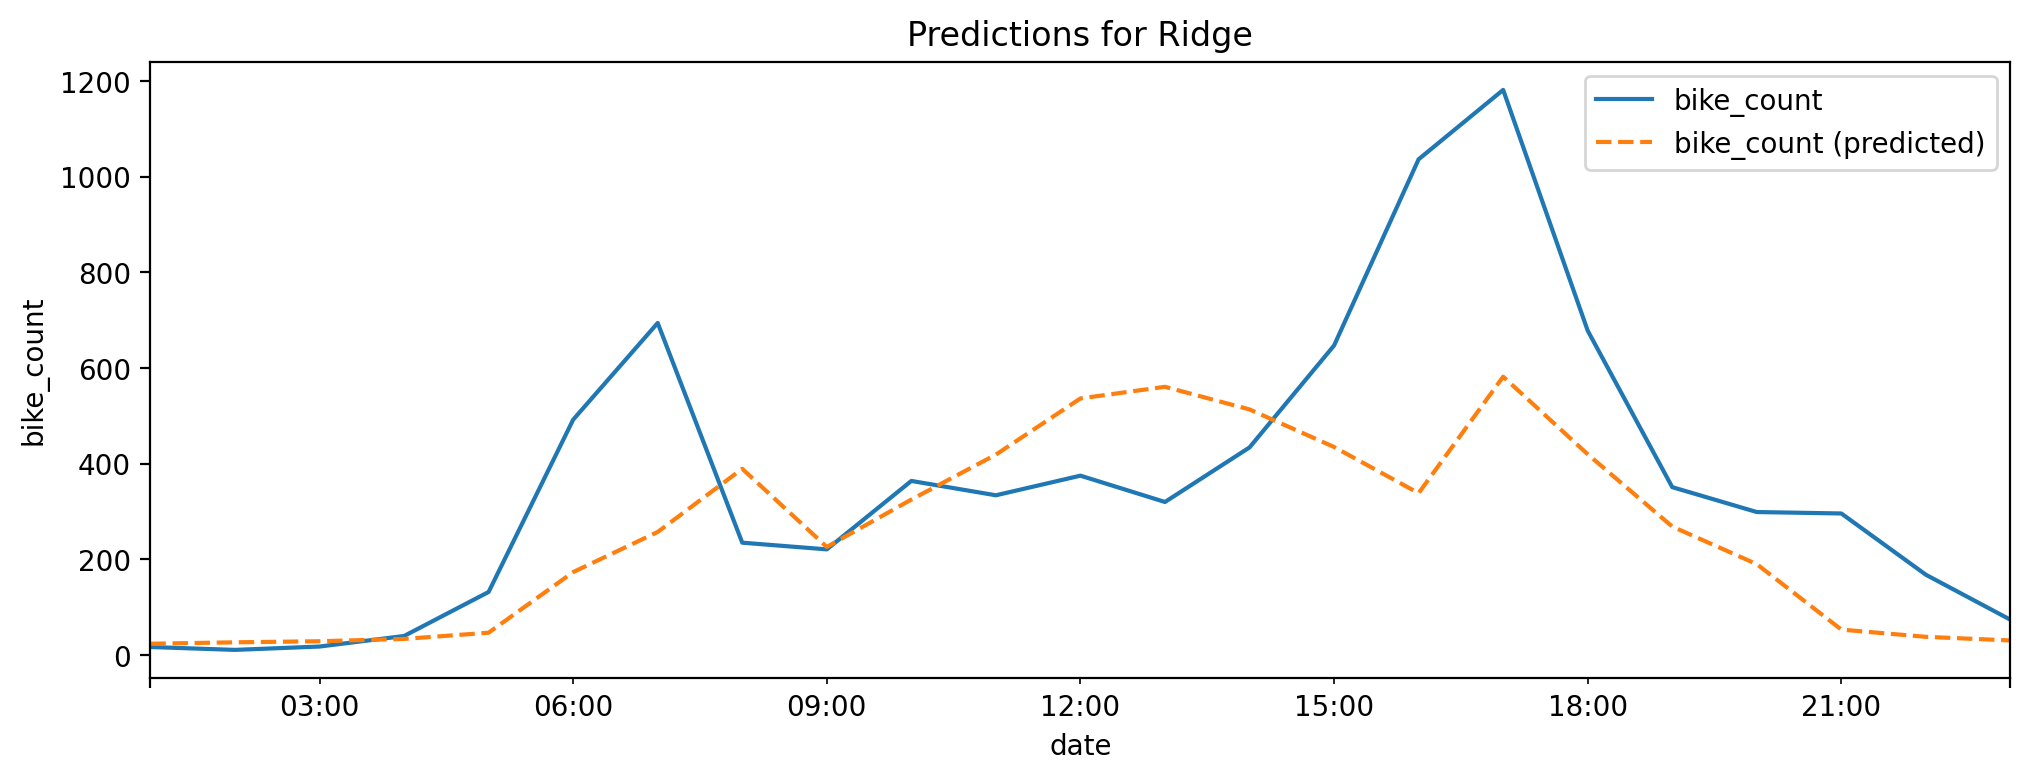

In [72]:
helper_functions.sample_day_plot(X_test, y_test_prediction, y_test, 'Ridge', results_path)

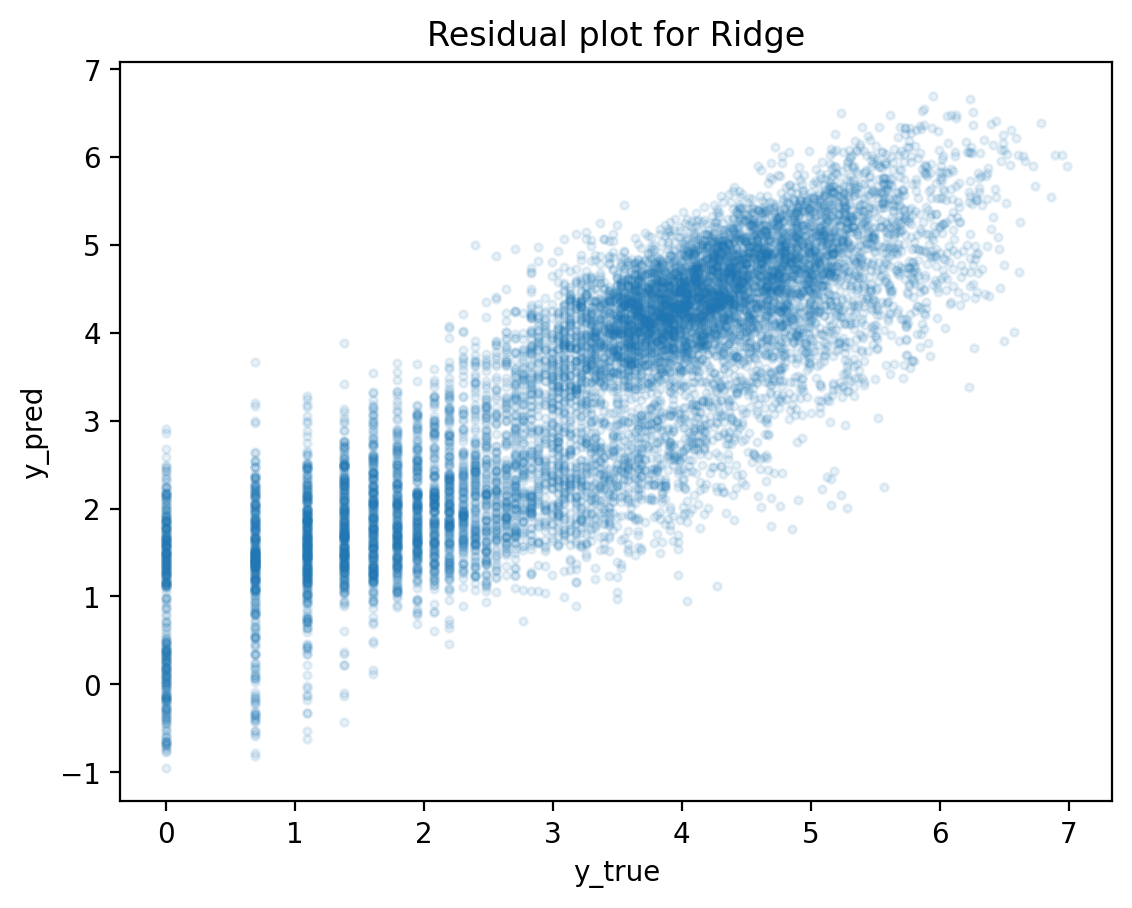

In [73]:
helper_functions.residual_plot(y_test_prediction, y_test, 'Ridge', results_path)

# Combined Analysis

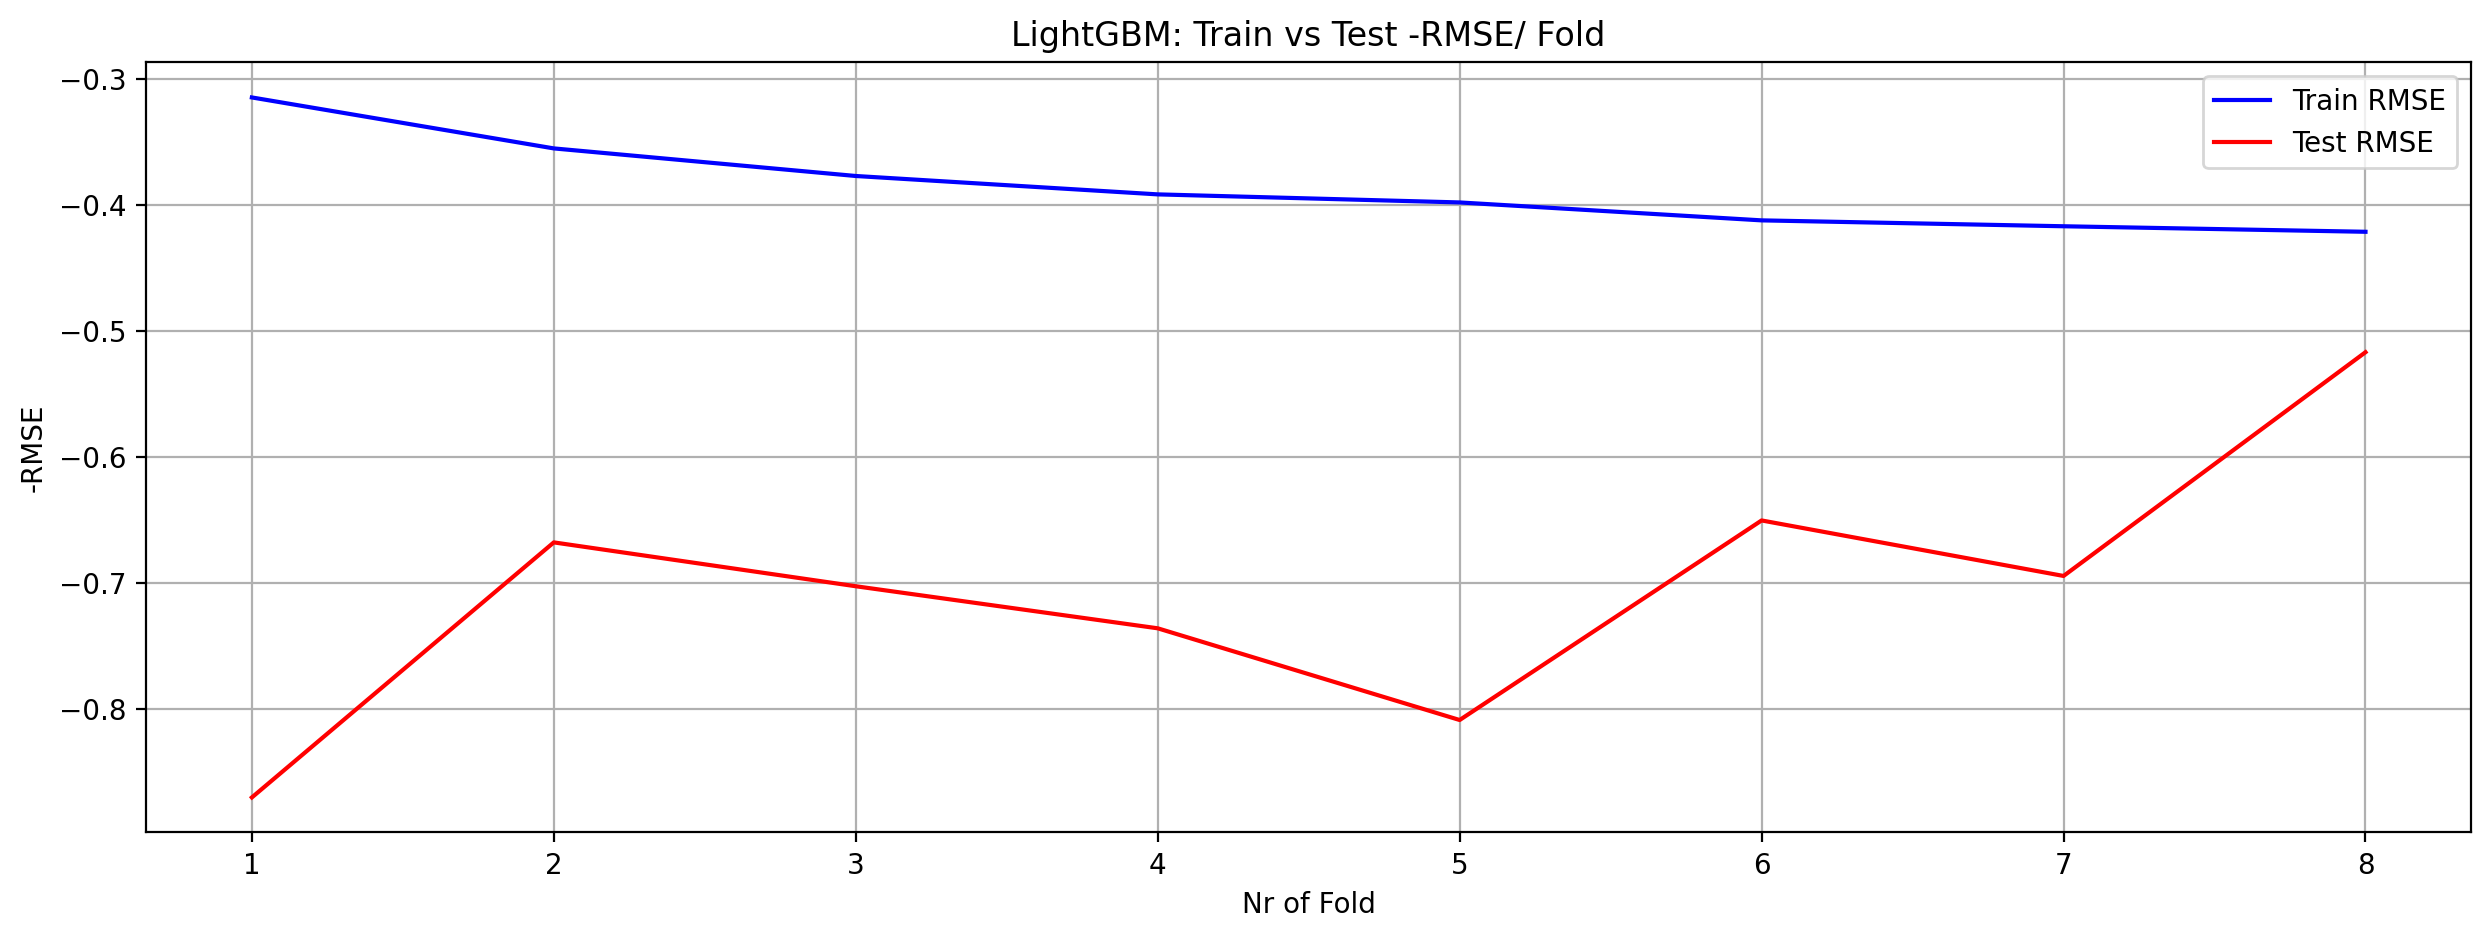

In [74]:
helper_functions.rmse_test_train_plot(light_gbm_max_params, 'LightGBM', results_path)

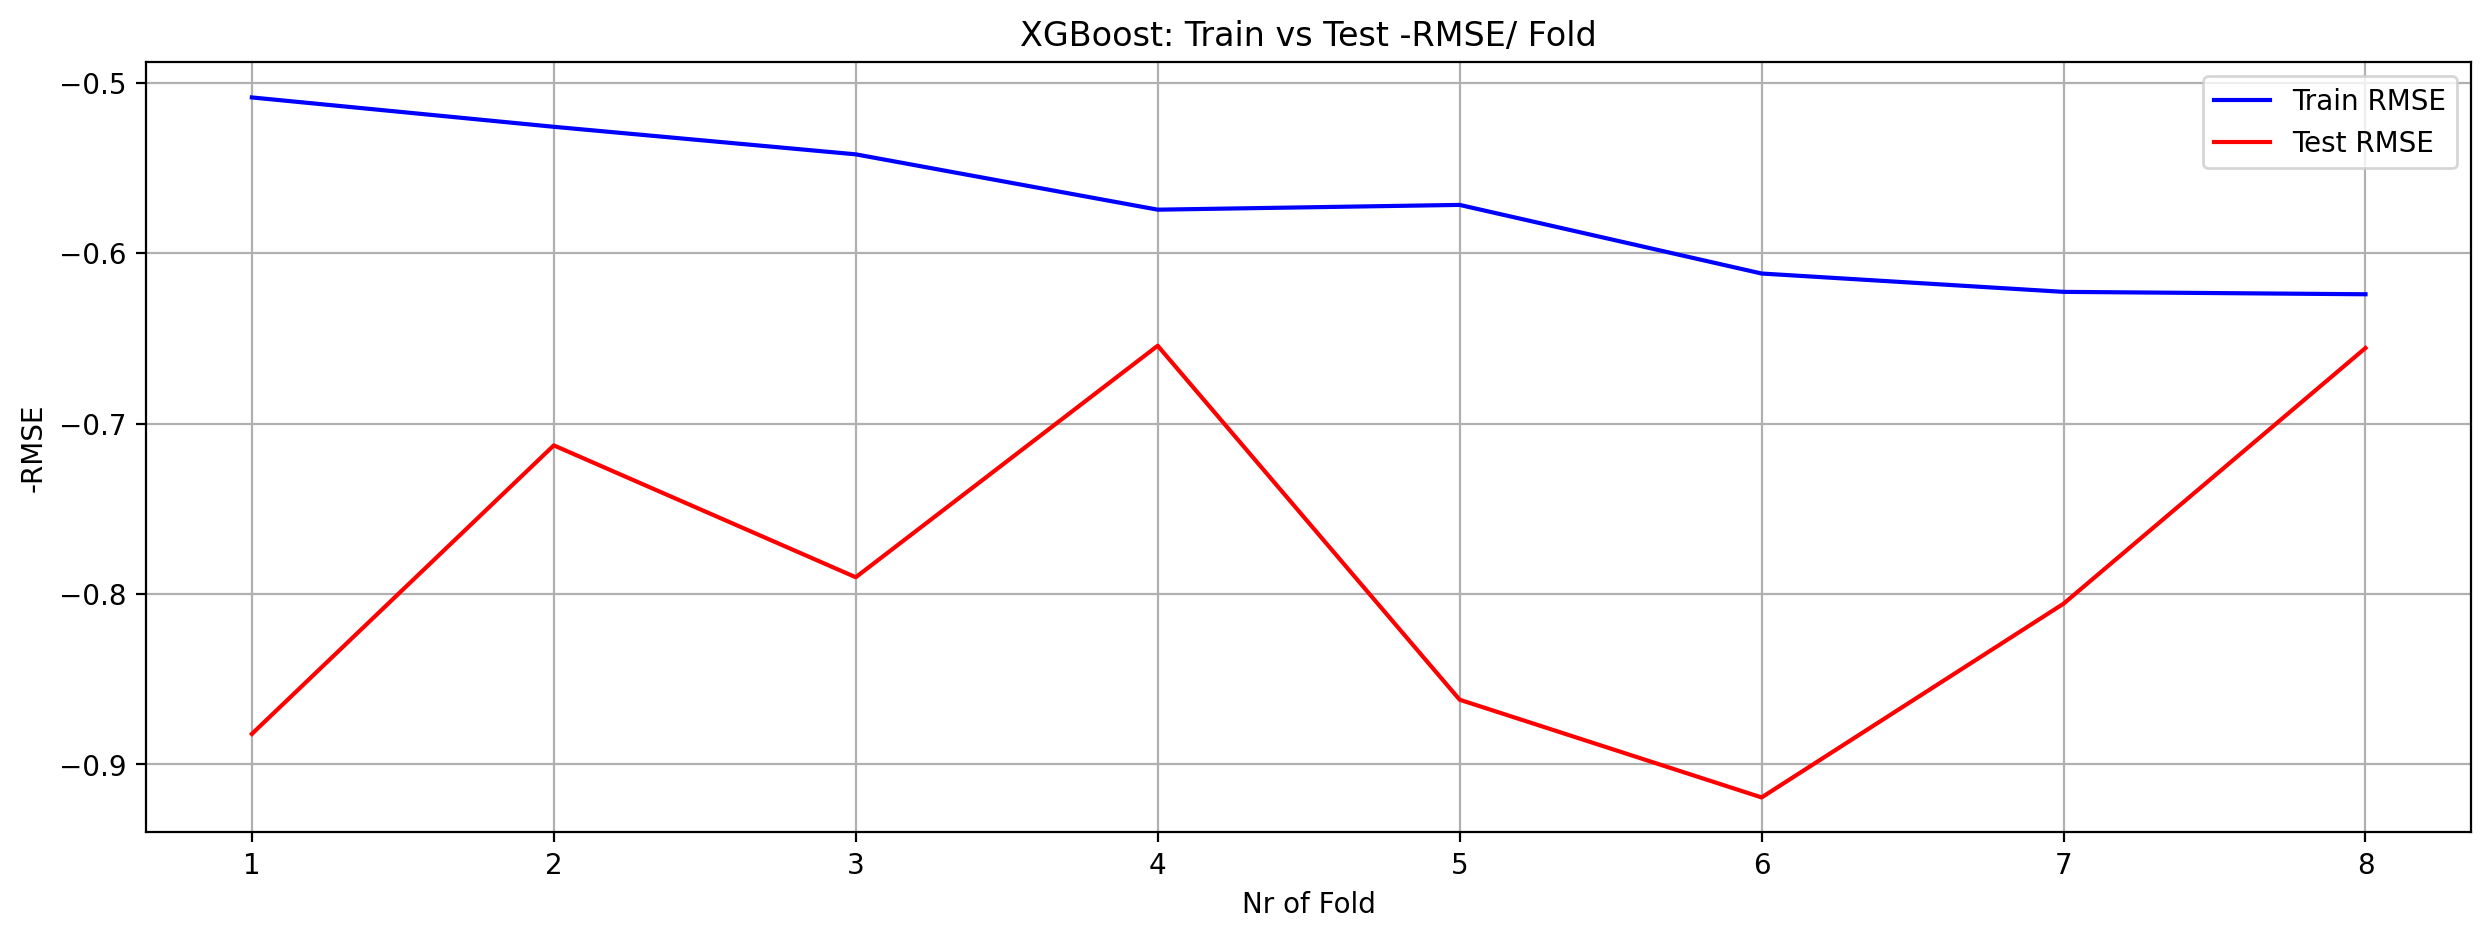

In [75]:
helper_functions.rmse_test_train_plot(xgb_max_params, 'XGBoost', results_path)

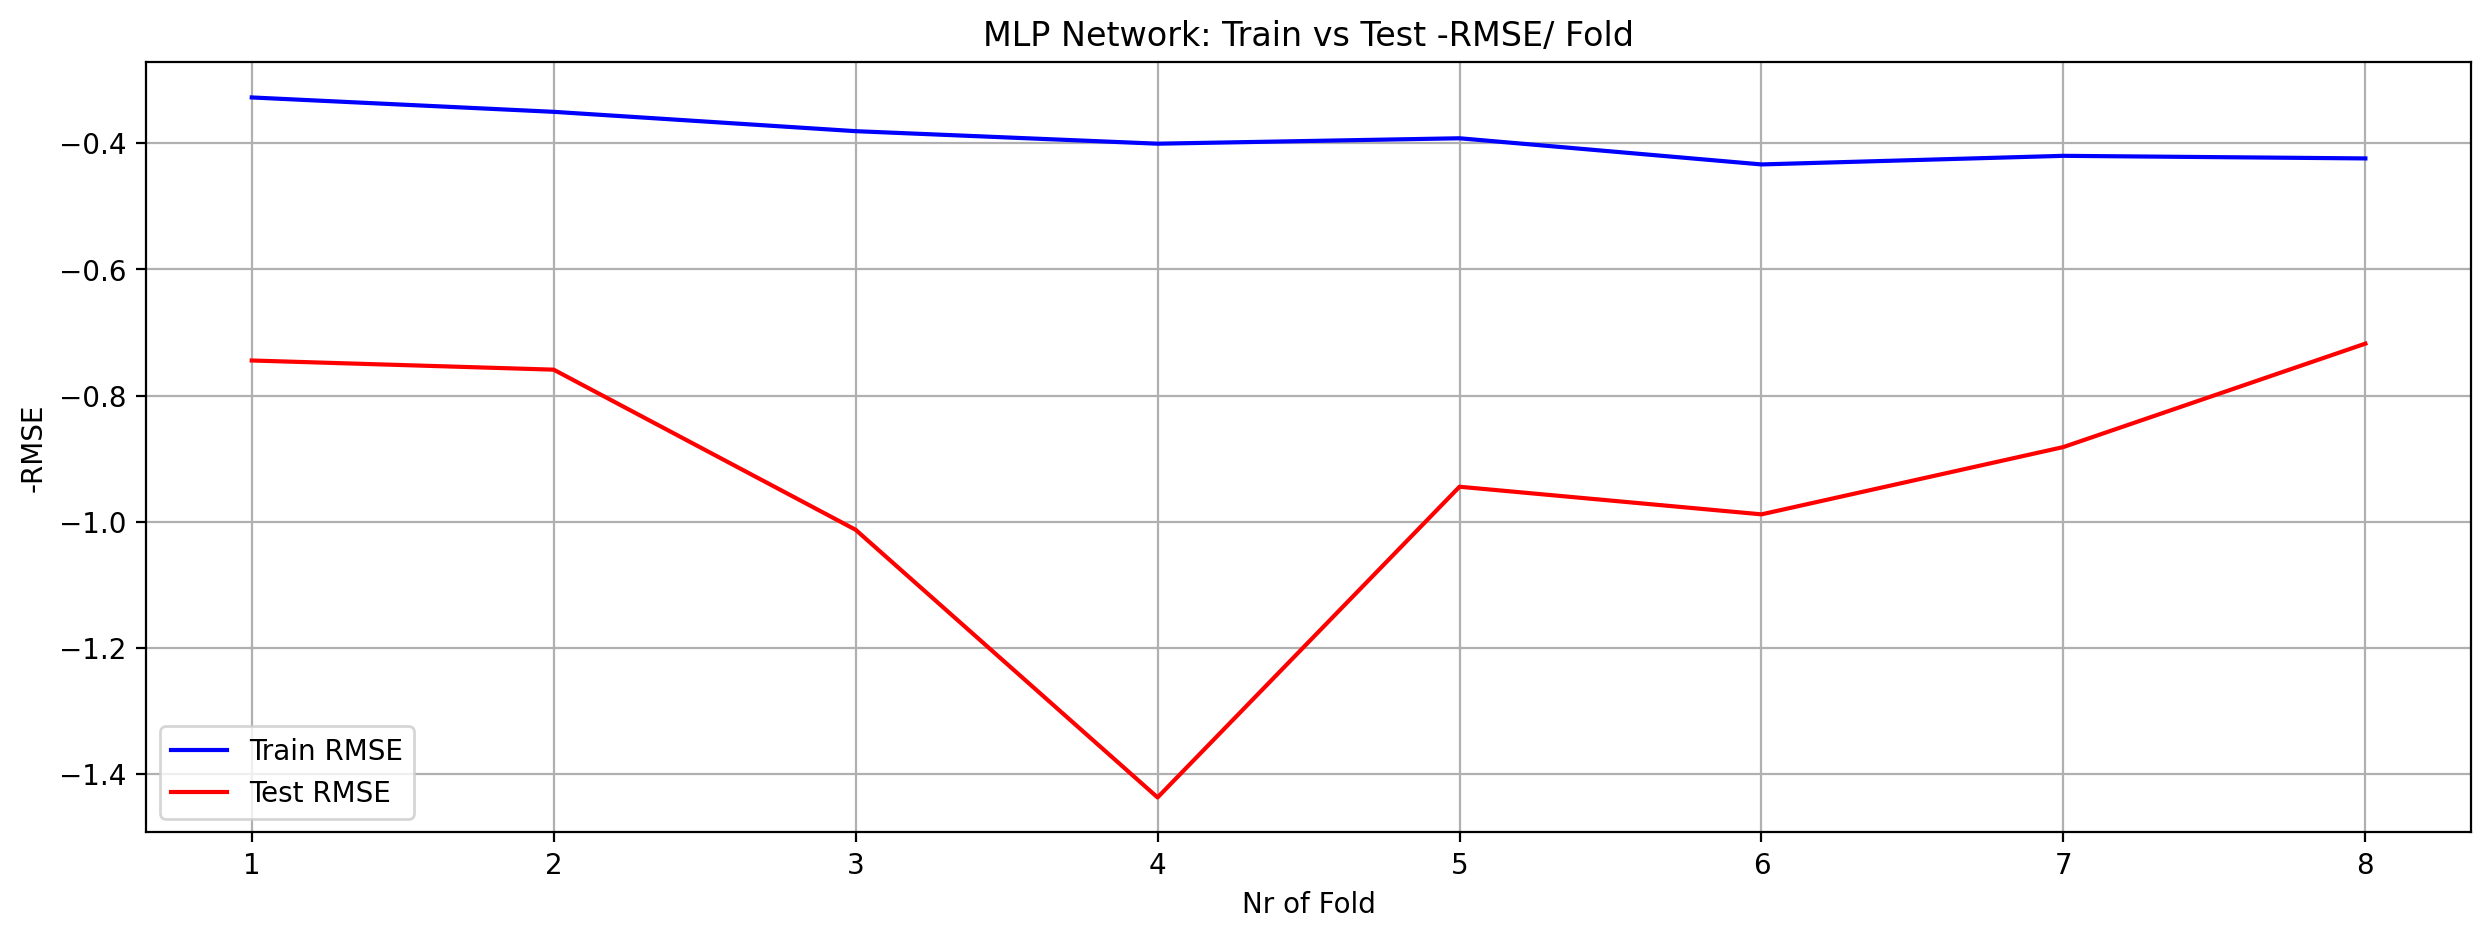

In [76]:
helper_functions.rmse_test_train_plot(mlp_max_params, 'MLP Network', results_path)

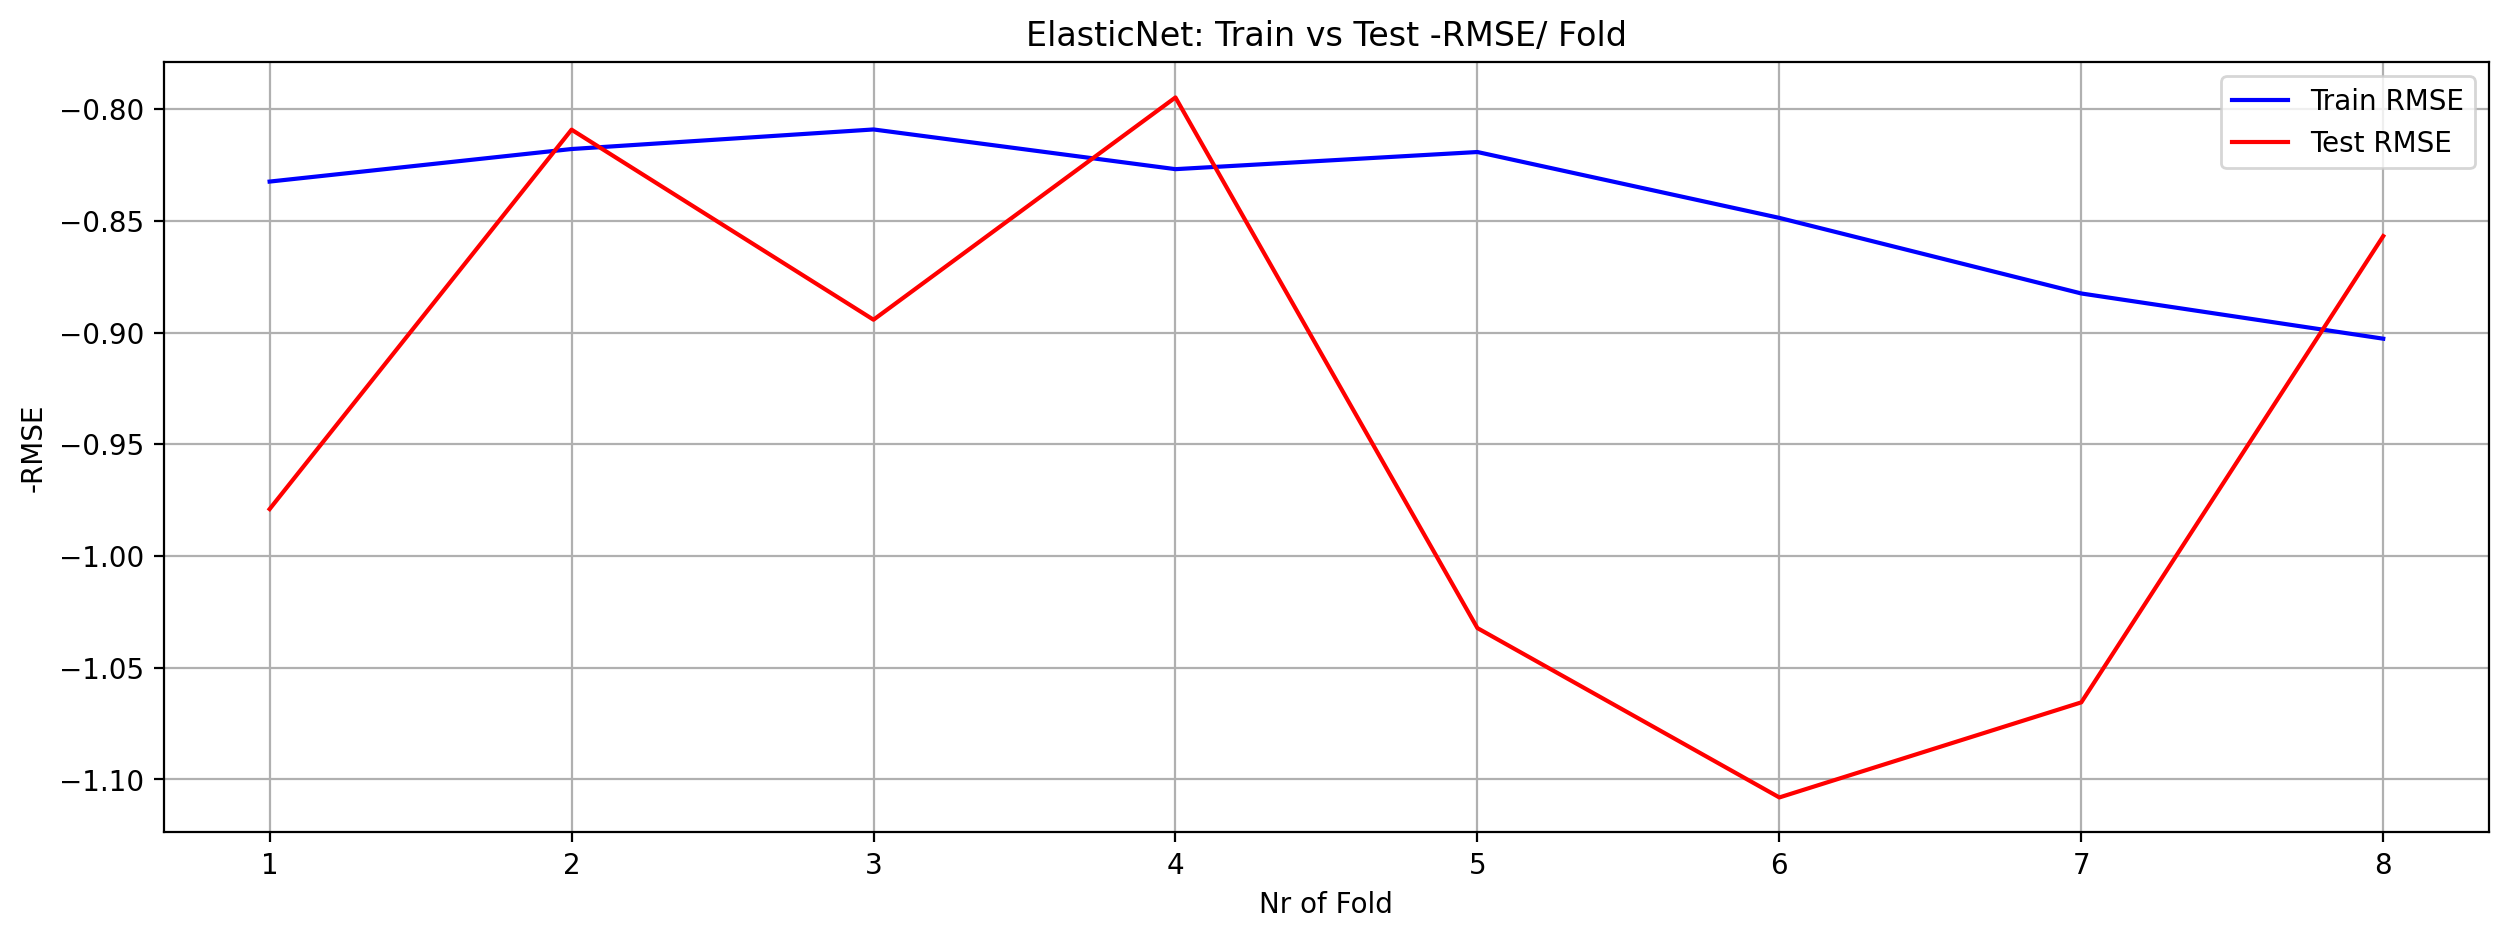

In [77]:
helper_functions.rmse_test_train_plot(elasticnet_max_params, 'ElasticNet', results_path)

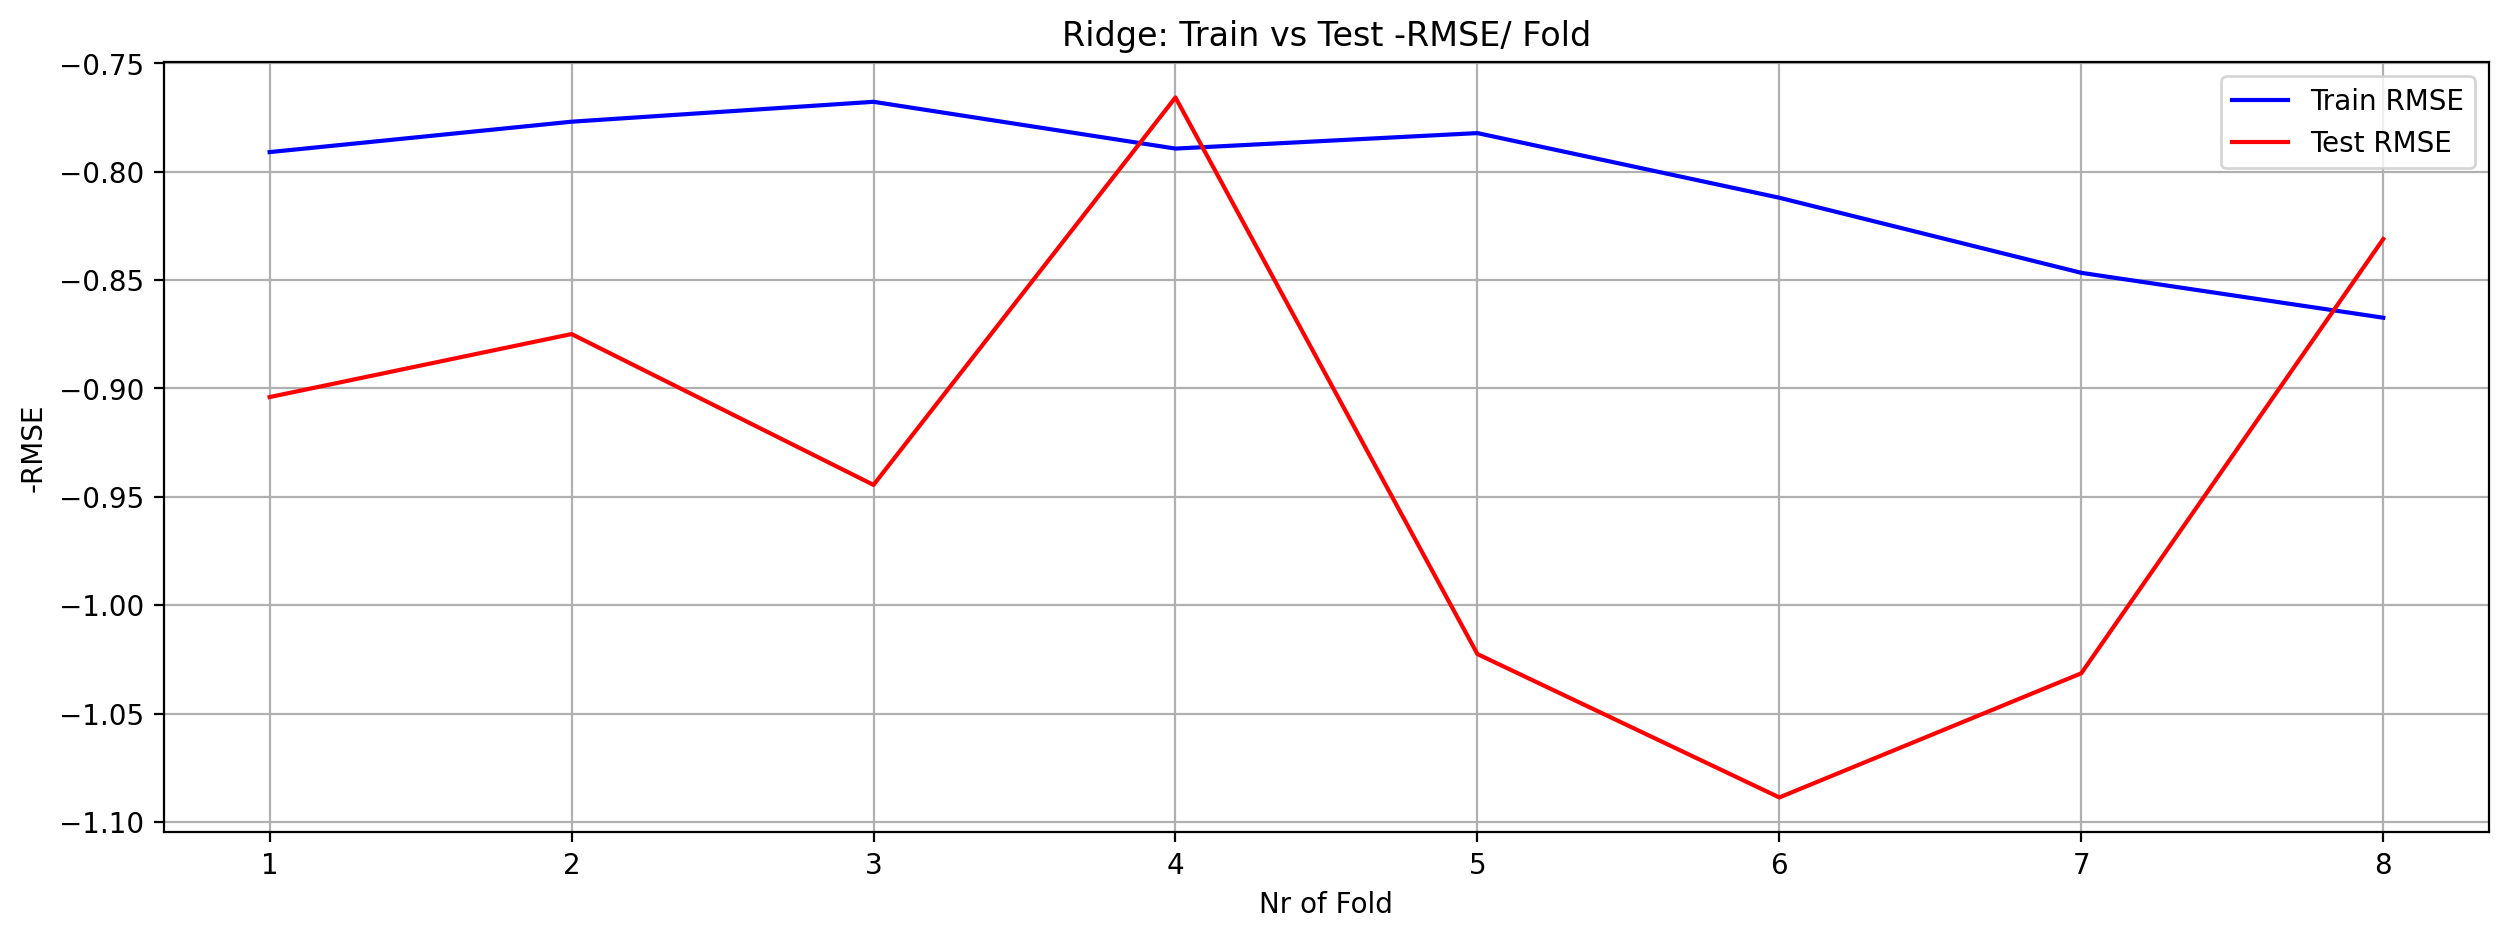

In [78]:
helper_functions.rmse_test_train_plot(ridge_max_params, 'Ridge', results_path)

In [92]:
names = ['LightGBM', 'XGBoost', 'MLP Network', 'ElasticNet', 'Ridge']
test_values = ['split0_test_score', 'split1_test_score', 'split2_test_score',
   'split3_test_score', 'split4_test_score', 'split5_test_score',
   'split6_test_score', 'split7_test_score']
train_values = ['split0_train_score',
   'split1_train_score', 'split2_train_score', 'split3_train_score',
   'split4_train_score', 'split5_train_score', 'split6_train_score',
   'split7_train_score']


results_train = []
results_test = []

for params in [light_gbm_max_params, xgb_max_params, mlp_max_params, elasticnet_max_params, ridge_max_params]:
    results_train.append(params[train_values].values[0])
    results_test.append(params[test_values].values[0])



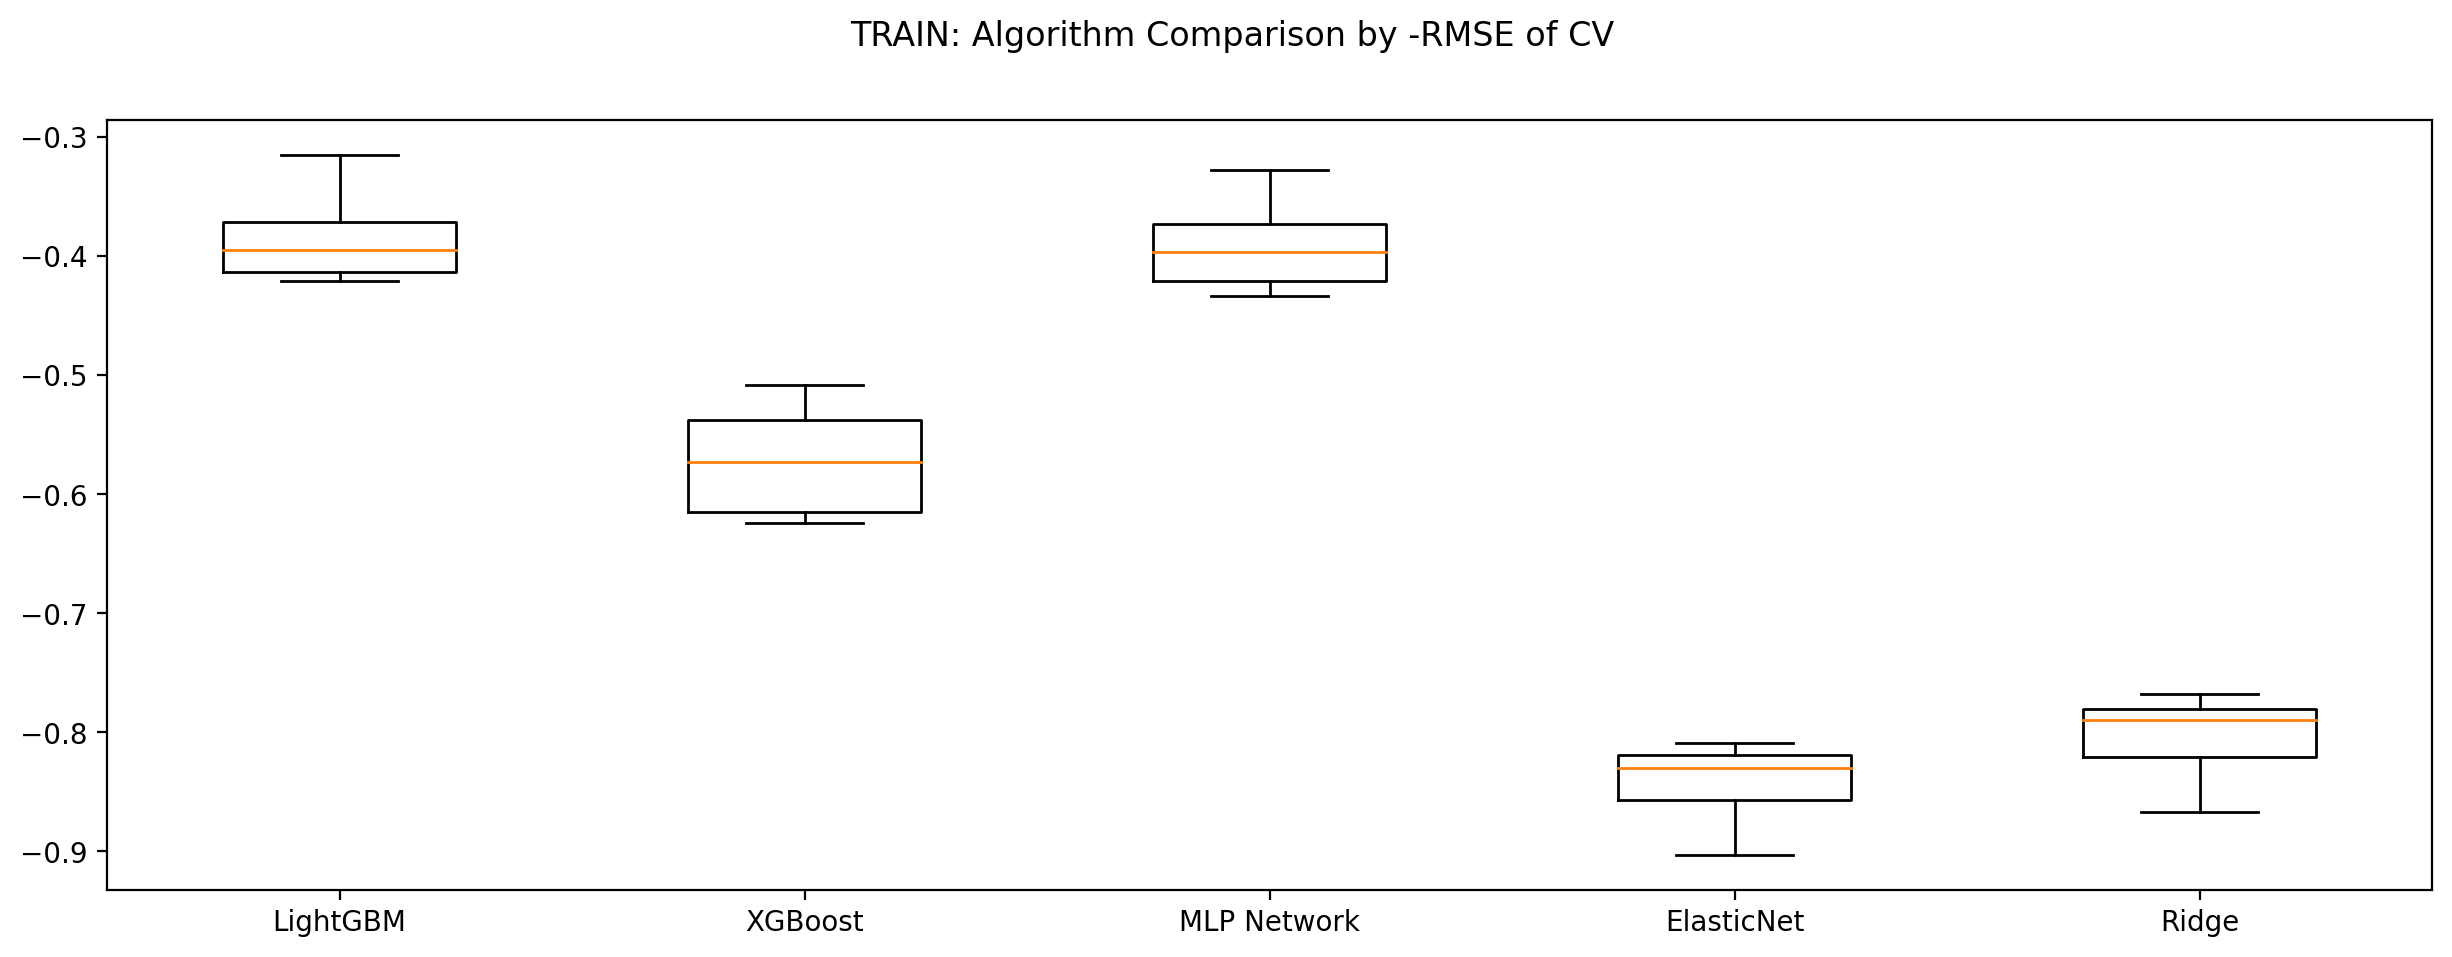

In [94]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(15, 5))
fig.suptitle('TRAIN: Algorithm Comparison by -RMSE of CV')

ax = fig.add_subplot(111)

plt.boxplot(results_train)
ax.set_xticklabels(names)
plt.savefig(f'{results_path}/train_boxplot.png')

plt.show()

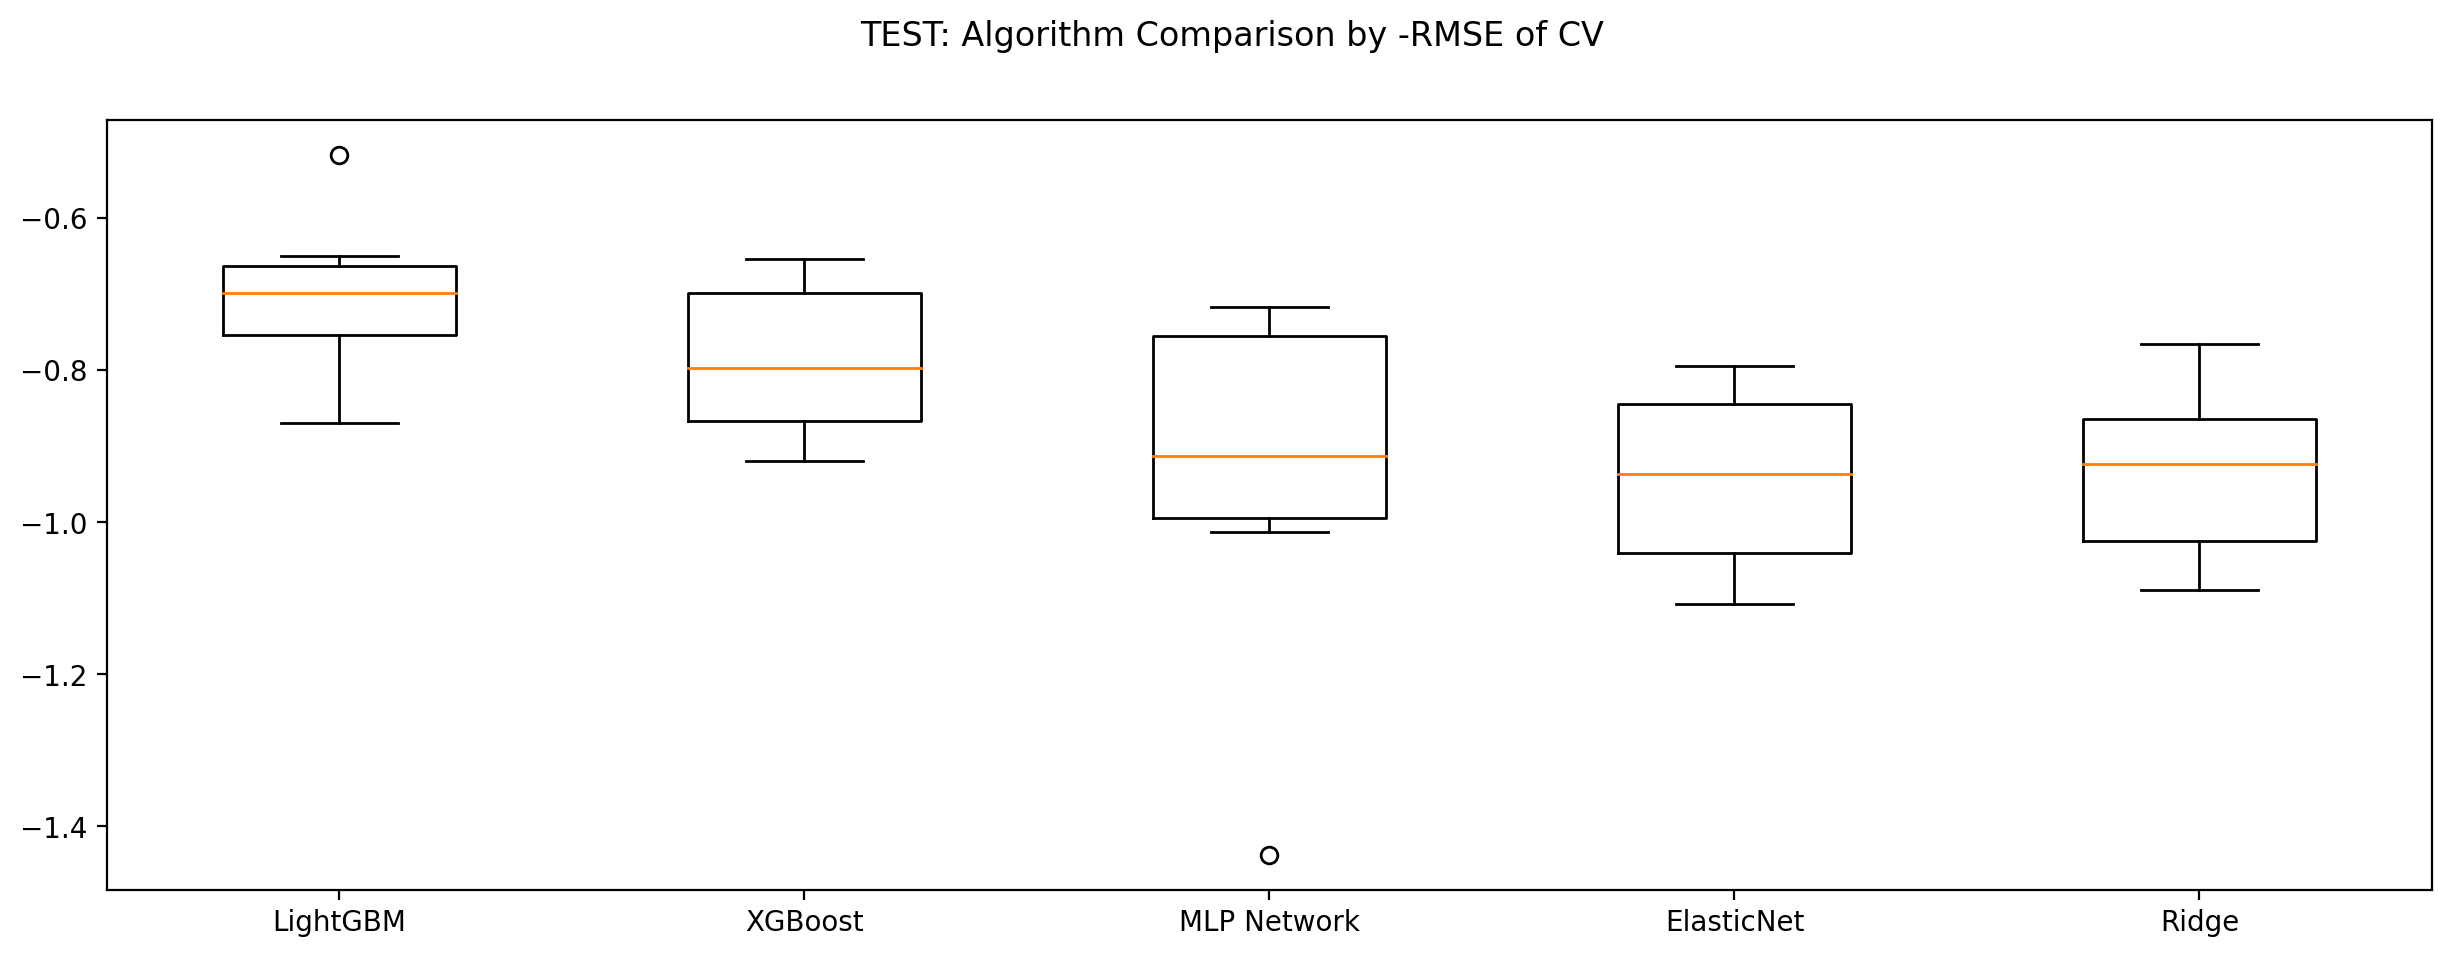

In [95]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(15, 5))
fig.suptitle('TEST: Algorithm Comparison by -RMSE of CV')

ax = fig.add_subplot(111)

plt.boxplot(results_test)
ax.set_xticklabels(names)
plt.savefig(f'{results_path}/test_boxplot.png')

plt.show()
